In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import random
import pandas as pd
import multiprocessing as mp
import numpy as np
import osmnx as ox
import json
import networkx as nx
import pickle
from data_utils import *
import matplotlib

from scipy.stats import pearsonr, gamma, kstest, ks_2samp, wilcoxon
from scipy.stats import ttest_rel, ttest_ind
from scipy.stats import friedmanchisquare
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
from acp import *

## Démarche 

### Test students : comparaison score moyen courts / frais
### Trade off distance / fraîcheur
### Caractérisation des segments les plus fréquentés
#### ACP
#### Distribution des proportions / comparaison avec distribution initiale

In [5]:
edges_buffer_scored_path = "output_data/analyse/edges_all_prop.gpkg"
edges_prop = gpd.read_file(edges_buffer_scored_path)
edges_prop.head()

,u,v,key,osmid,oneway,name,highway,maxspeed,reversed,length,...,prairies_prop,ombres_08_prop,ombres_13_prop,ombres_18_prop,arbustes_prop,arbres_prop,C_wavg_scaled,eaux_prop,canop,geometry
0,143403,21714981,0,120412669,False,Rue Professeur Morat,residential,30,False,12.119,...,0.0,0.00,0.0,0.00,0.0,0.60,0.588824,0.0,0.0,"POLYGON ((1846109.564 5172145.602, 1846110.144..."
1,143403,9226919131,0,521119804,True,Avenue Jean Mermoz,primary,50,False,26.832,...,0.0,0.00,0.0,0.00,0.0,0.91,0.588824,0.0,0.0,"POLYGON ((1846084.687 5172144.567, 1846084.135..."
2,143403,9226887756,0,120412669,False,Rue Professeur Morat,residential,30,True,11.073,...,0.0,0.76,0.0,0.00,0.0,0.30,0.588824,0.0,0.0,"POLYGON ((1846122.675 5172142.519, 1846122.463..."
3,143403,10810932922,0,521119804,True,Avenue Jean Mermoz,primary,50,False,15.606,...,0.0,0.36,0.0,0.00,0.0,0.72,0.588824,0.0,0.0,"POLYGON ((1846109.345 5172134.084, 1846108.797..."
4,21714981,9226922647,0,4087154,True,Rue Professeur Morat,unclassified,30,False,8.969,...,0.0,0.00,0.0,0.69,0.0,0.32,0.592353,0.0,0.0,"POLYGON ((1846096.611 5172125.102, 1846096.085..."


In [27]:
final_network_path = "./output_data/network/graph/final_network_all_1.gpkg"
graph = gpd.read_file(final_network_path, layer="edges")

In [28]:
edges_prop = edges_prop.set_index(["uniqId"])
graph = graph.set_index(["uniqId"])

## ALL 1
Tous les poids des variables sont à 1. 

### Test students

In [9]:
def len_if_group(all_it_path):
    all_it = pd.read_csv(all_it_path)

    it_if = all_it[all_it["type"] == "IF"]
    it_len = all_it[all_it["type"] == "LEN"]
    
    return it_if, it_len

def ks_2samp_test(group1, group2, alternative):
    KS, p_value = ks_2samp(group1, group2, alternative=alternative)
    print("KS statistics : ", KS)
    print("p-value : ", p_value)
    return KS, p_value

def test_students(group1, group2, alternative="two-sided"):
    """In order to compare the mean between the distribution of group 1 and group 2"""
    return ttest_rel(group1, group2, alternative=alternative)

def d_cohen(group1, group2):
    """In order to know if there is a size effect"""
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)

    var1 = np.var(group1, ddof=1)
    var2 = np.var(group2, ddof=2)
    
    n1 = len(group1)
    n2 = len(group2)

    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

    return (mean1 - mean2) / pooled_std

def distance_cost(group1, group2):
    """Calculate the distance cost between itineraries"""
    d1 = np.array(group1["total_length"])
    d2 = np.array(group2["total_length"])

    percent_diff = ((d2-d1)/d1)*100

    return round(np.mean(percent_diff),2)

def select_most_frequent_index(frequency_data, quantile):
    limit_count = frequency_data["count"].quantile([quantile]).iloc[0]
    most_frequent = frequency_data[frequency_data["count"] >= limit_count]
    
    percent = (len(most_frequent)/len(frequency_data))*100
    
    print(f"percent most frequent :", percent)
    
    indexes_most_frequent = most_frequent.index.to_list()
    
    return indexes_most_frequent

def plot_data(data, name, max_y_value):
    # Calculate the common x-axis limits
    min_value = data.min()
    max_value = data.max()

    #Calculate the common y-axis limits
    min_y_value = 0
    max_y_value = max_y_value

    fig1 = plt.figure(figsize=(8, 6))
    plt.hist(data, bins=20, alpha=0.5, color="green")
    plt.xlabel(f"{name}")
    plt.ylabel("Frequency")
    plt.title(f"Histogram - {name}")
    plt.grid(True)
    plt.xlim(min_value, max_value)
    plt.ylim(min_y_value, max_y_value)

    mean = np.mean(data)
    var = np.var(data)
    std = np.std(data)
    quartiles = np.percentile(data, [25, 50, 75])
    sample_size = len(data)

    plt.axvline(mean, color='black', linestyle='dashed', linewidth=1)
    plt.axvline(quartiles[0], color='red', linestyle='dashed', linewidth=1)
    plt.axvline(quartiles[1], color='red', linestyle='solid', linewidth=1)
    plt.axvline(quartiles[2], color='red', linestyle='dashed', linewidth=1)

    plt.text(0.95, 0.95, f"Mean: {mean:.2f}\nVariance: {var:.2f}\nStd Deviation: {std:.2f}\n"
                         f"Q1: {quartiles[0]:.2f}\nQ2: {quartiles[1]:.2f}\nQ3: {quartiles[2]:.2f}\n"
                         f"Sample Size : {sample_size}",
             verticalalignment="top", horizontalalignment="right", transform=plt.gca().transAxes)

    plt.show()


def convert_score_on_ten(x, max):
    return (10/max)*x

def plot_distribution_by_category(dataframe, target_column, category_column, category_colors=None):
    """
    Plot the distribution of a target column colored by a category column.
    
    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        target_column (str): The column whose distribution will be plotted.
        category_column (str): The column used for coloring the distribution.
        category_colors (dict, optional): A dictionary specifying the colors for each category. 
                                          If not provided, default colors will be used.
    """
    if category_colors is None:
        category_colors = {}  # Default colors if not provided
        unique_categories = dataframe[category_column].unique()
        default_colors = plt.cm.tab10.colors
        for i, cat in enumerate(unique_categories):
            category_colors[cat] = default_colors[i % len(default_colors)]

    # Extract data for plotting
    data_to_plot = dataframe[[target_column, category_column]]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot the histograms colored by category
    for cat, group in data_to_plot.groupby(category_column):
        ax1.hist(group[target_column], bins=10, alpha=0.6, color=category_colors[cat], label=cat)
        ax2.hist(group[target_column], bins=10, alpha=0.6, color=category_colors[cat], label=cat)

    # Calculate and display descriptive statistics
    descriptive_stats = dataframe.groupby(category_column)[target_column].describe()
    for cat in descriptive_stats.index:
        mean = descriptive_stats.loc[cat, 'mean']
        variance = descriptive_stats.loc[cat, 'std'] ** 2
        q25 = descriptive_stats.loc[cat, '25%']
        q50 = descriptive_stats.loc[cat, '50%']
        q75 = descriptive_stats.loc[cat, '75%']
        ax2.axvline(mean, color=category_colors[cat], linestyle='dashed', linewidth=1)
        ax2.axvline(q25, color=category_colors[cat], linestyle='dotted', linewidth=1)
        ax2.axvline(q50, color=category_colors[cat], linestyle='dotted', linewidth=1)
        ax2.axvline(q75, color=category_colors[cat], linestyle='dotted', linewidth=1)

    # Set plot properties
    ax1.set_xlabel(target_column)
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Distribution of {target_column} by {category_column}')
    ax1.legend()

    ax2.set_xlabel(target_column)
    ax2.set_title('Descriptive Statistics')
    ax2.grid(True)

    # Add a legend for descriptive statistics
    legend_elements = [plt.Line2D([0], [0], color=category_colors[cat], lw=1, label=cat) for cat in descriptive_stats.index]
    ax2.legend(handles=legend_elements, title=category_column)

    plt.tight_layout()
    plt.show()

    def sns_plot(data, variable):
        sns.set(rc={'axes.facecolor':'#f4f2f2', 'figure.facecolor':'#f4f2f2'})
        colour_palette = {"IF": "blue", "LEN": "red"}
        legend = {"IF": "Frais", "LEN": "Courts"}
        sns.displot(data, x=variable, kind="kde", hue="type", fill=True, legend=False, palette=colour_palette)

        plt.ylabel("Densité")
        plt.xlabel("")

        plt.legend(title="Types d'itinéraires", labels=legend.values())
        plt.show()

def sns_plot(data, variable):
    sns.set(rc={'axes.facecolor':'#f4f2f2', 'figure.facecolor':'#f4f2f2'})
    colour_palette = {"IF": "blue", "LEN": "red"}
    legend = {"IF": "Frais", "LEN": "Courts"}
    sns.displot(data, x=variable, kind="kde", hue="type", fill=True, legend=False, palette=colour_palette)

    plt.ylabel("Densité")
    plt.xlabel("")

    plt.legend(title="Types d'itinéraires", labels=legend.values())
    plt.show()

def basic_stats(data):
    return pd.DataFrame({
        "mean": np.mean(data),
        "var": np.var(data),
        "quantiles": np.quantile(data, q=[0.25,0.5,0.75])
    })

def compare_gain(it_if, it_len, printed=True, q=[0.25,0.5,0.75]):
    all_percent_diff = []
    for i, l in zip(it_if, it_len):
        percent = round(((i - l)/(l+0.000001))*100, 2)
        all_percent_diff.append(percent)
    
    if(printed):
        print("Gain quantiles : ", np.quantile(all_percent_diff, q=q))
        print("Gain mean : ", np.mean(all_percent_diff))
    return all_percent_diff

In [41]:
dataset_output_path = "./output_data/analyse/dataset_all_1.gpkg"

In [42]:
dataset_all_1 = gpd.read_file(dataset_output_path)
dataset_all_1 = dataset_all_1.set_index(["uniqId"])

In [142]:
all_it_path = "./output_data/analyse/mean_score_all_1.csv"

it_if, it_len = len_if_group(all_it_path)
print(f"Test de student : {test_students(it_len['score'], it_if['score'], alternative='greater')}")
print(f"D de cohen : {d_cohen(it_len['score'], it_if['score'])}")

print(f"Coût de distance : ", distance_cost(it_len, it_if))

Test de student : TtestResult(statistic=21.150347773690196, pvalue=1.2333466715481158e-87, df=1534)
D de cohen : 0.2459494199902906
Coût de distance :  0.66


Test de student OK mais pas d de cohen => peu d'effet de la fraîcheur

Un coût de distance très négligeable : moins de 1%
La différence entre les deux types d'itinéraires n'est pas flagrante. Logique à priori.

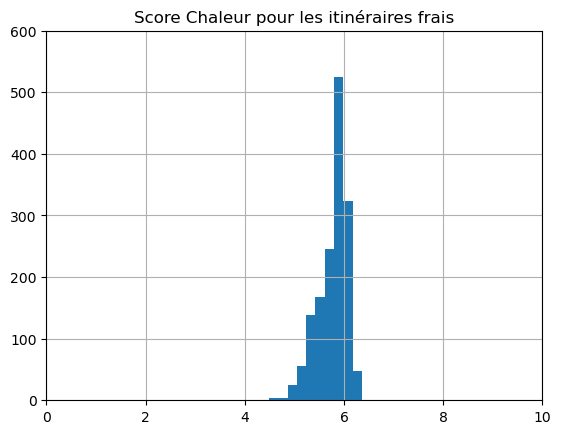

In [4]:
it_if["score"].hist()
plt.xlim([0,10])
plt.ylim([0,600])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

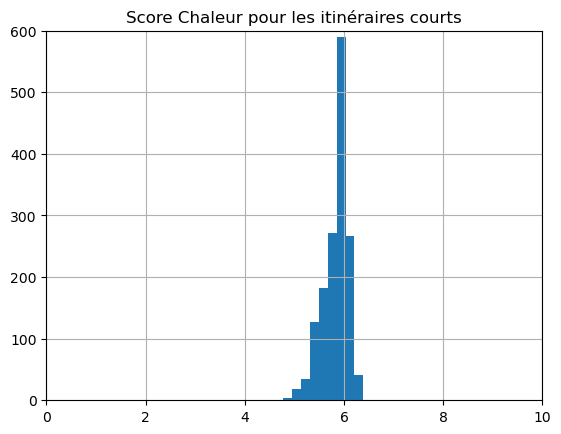

In [37]:
it_len["score"].hist()
plt.xlim([0,10])
plt.ylim([0,600])
plt.title("Score Chaleur pour les itinéraires courts")
plt.show()

Avec des poids à 1 pour chacune des données, on observe clairement la même distribution au niveau des scores.

### Analyse des segments les plus fréquentés

In [18]:
frequency_if_path = "./output_data/analyse/frequency_if_all_1.gpkg"
frequency_len_path = "./output_data/analyse/frequency_len_all_1.gpkg"
frequency_if = gpd.read_file(frequency_if_path)
frequency_len = gpd.read_file(frequency_len_path)

# frequency_if = frequency_if.set_index(["u", "v", "key"])
# frequency_len = frequency_len.set_index(["u", "v", "key"])
frequency_if = frequency_if.set_index(["uniqId"])
frequency_len = frequency_len.set_index(["uniqId"])

In [19]:
frequency_if.columns

Index(['u', 'v', 'key', 'count', 'score_08', 'score_13', 'score_18',
       'geometry'],
      dtype='object')

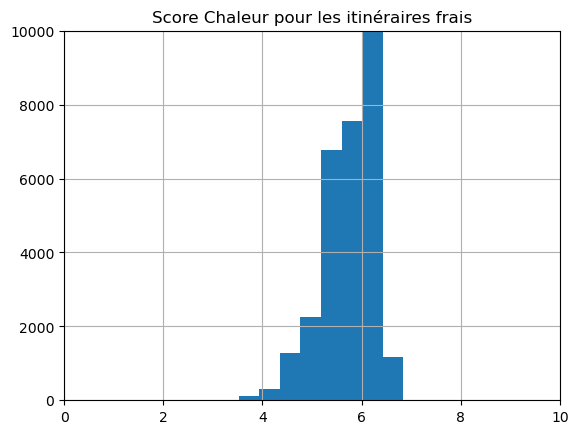

In [20]:
frequency_if["score_08"].hist()
plt.xlim([0,10])
plt.ylim([0,10000])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

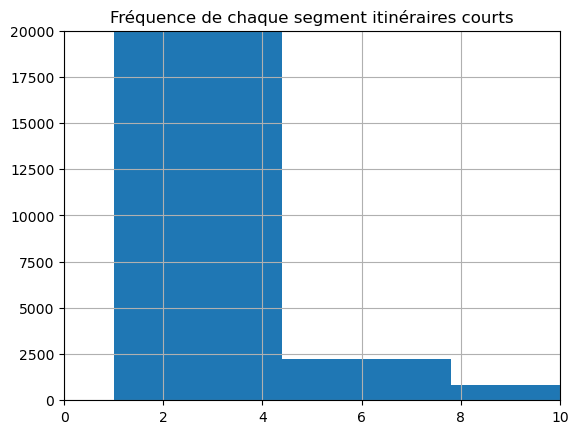

In [38]:
frequency_if["count"].hist()
plt.xlim([0,10])
plt.ylim([0,20000])
plt.title("Fréquence de chaque segment itinéraires courts")
plt.show()

In [21]:
pd.DataFrame(frequency_if["count"]).quantile([0.91]).iloc[0]

count    5.0
Name: 0.91, dtype: float64

Si on regarde la population des 10% segments les plus fréquentés

In [22]:
most_frequent_if = frequency_if[frequency_if["count"] >= 6]

In [23]:
print(len(frequency_if))
print(len(most_frequent_if))

print(round(len(most_frequent_if)/len(frequency_if),2))

29512
2436
0.08


In [24]:
frequency_if.head()

,u,v,key,count,score_08,score_13,score_18,geometry
uniqId,,,,,,,,
14340392268877560,143403,9226887756,0,1,5.351,6.111,6.111,"LINESTRING (4.87762 45.73390, 4.87761 45.73387..."
143403108109329220,143403,10810932922,0,1,5.331,5.691,5.691,"LINESTRING (4.87772 45.73377, 4.87754 45.73383)"
143408217149800,143408,21714980,0,1,6.261,5.981,6.261,"LINESTRING (4.87633 45.73413, 4.87634 45.73421)"
14341283608074510,143412,8360807451,0,2,6.352,6.012,5.512,"LINESTRING (4.86282 45.73848, 4.86286 45.73847)"
14341283608074610,143412,8360807461,0,6,6.352,5.662,5.572,"LINESTRING (4.86272 45.73851, 4.86282 45.73848)"


In [31]:
most_frequent_if_index = select_most_frequent_index(frequency_if, 0.9)
print(most_frequent_if_index)

most_frequent_if = frequency_if.loc[most_frequent_if_index]

percent most frequent : 11.737598265112496
['14341283608074610', '14341333877822070', '1952414122856580', '195250253374570', '19525012712971780', '195251240098410', '195251260593020', '195251260593030', '19525220928536580', '195253260586510', '19525320864025410', '19525687848190190', '19526126514355430', '19526161422855830', '19527634161962530', '19528220864025270', '58167863470654040', '739391473944770', '739447774531632430', '739491073949250', '7394910331492200', '739491073949250', '739492582075060', '739492521156773180', '808905992603684660', '808906251716328250', '820670013746387190', '137463871982071990', '820719974537450600', '820749324721235140', '820749333026226150', '739492582075060', '820750624721235140', '843366230880036650', '843366263667053150', '8433684331952040', '8433684331952080', '494237462084338080', '84340314922619780', '859156850164364510', '859243792494170', '85932794921502640', '859342515815851260', '869825688830290', '870268246746992940', '87039972657835270', '2

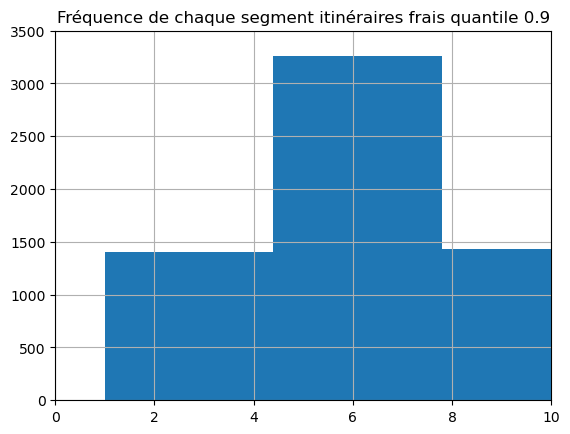

In [35]:
most_frequent_if["count"].hist()
plt.xlim([0,10])
plt.ylim([0,3500])
plt.title("Fréquence de chaque segment itinéraires frais quantile 0.9")
plt.show()

In [29]:
edges_prop_most_frequent_if = edges_prop.loc[most_frequent_if_index]

In [36]:
edges_prop_most_frequent_if.columns

Index(['u', 'v', 'key', 'osmid', 'oneway', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'from', 'to', 'lanes', 'width', 'service',
       'access', 'bridge', 'ref', 'junction', 'tunnel', 'est_width', 'area',
       'prairies_prop', 'ombres_08_prop', 'ombres_13_prop', 'ombres_18_prop',
       'arbustes_prop', 'arbres_prop', 'C_wavg_scaled', 'eaux_prop', 'canop',
       'geometry'],
      dtype='object')

#### Comparaison distribution Most frequent VS all + test de student

##### Arbres

In [4]:
dataset_all_1_arbres = edges_prop.loc[dataset_all_1.index.unique().to_list()]["arbres_prop"]

print(len(dataset_all_1_arbres))
print(len(edges_prop))

plot_data(dataset_all_1_arbres, "All Arbres", 10000)

NameError: name 'edges_prop' is not defined

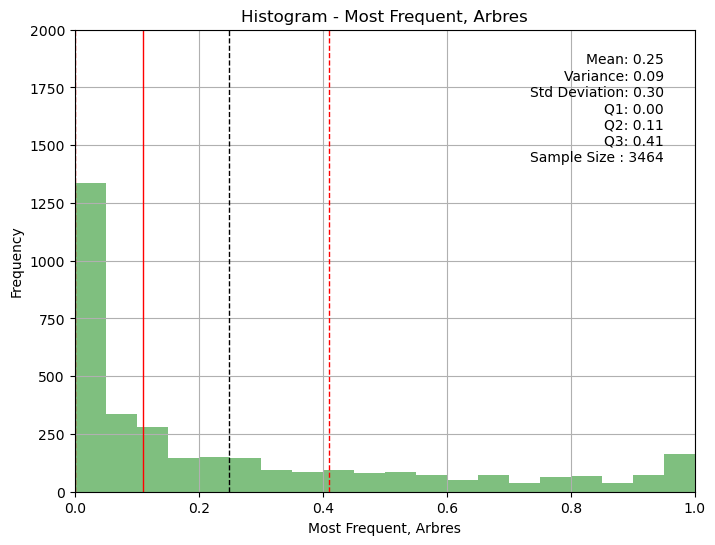

In [52]:
edges_prop_most_frequent_if_arbres = edges_prop_most_frequent_if["arbres_prop"]

plot_data(edges_prop_most_frequent_if_arbres, "Most Frequent, Arbres", 2000)

In [58]:
dataset_all_1_arbres_sample_index = random.sample(dataset_all_1_arbres.index.to_list(), len(edges_prop_most_frequent_if_arbres))
dataset_all_1_arbres_sample = dataset_all_1_arbres.loc[dataset_all_1_arbres_sample_index]

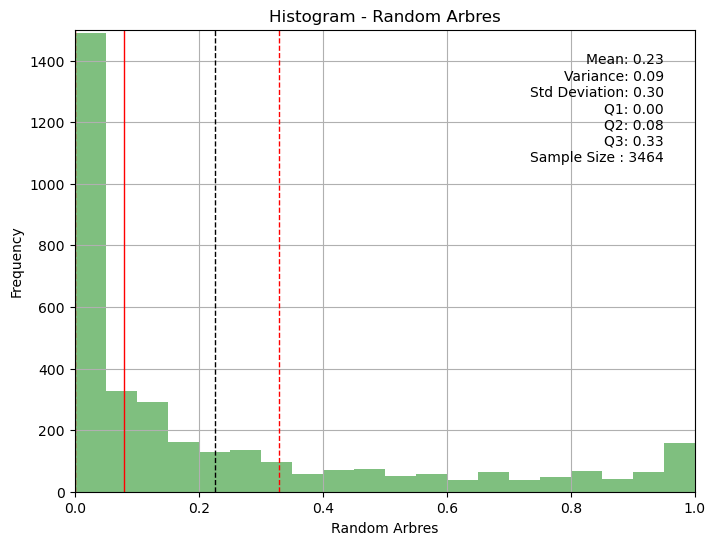

In [59]:
plot_data(dataset_all_1_arbres_sample, "Random Arbres", 1500)

Test de student pour comparer la moyenne de proportion entre des segment pris au hasard et les segments les plus fréquentés.
Le test de student n'est certainement pas adapté, puisque les données ne suivent pas une loi normale. Donc on utilise plutôt un test de Kolmogorov-Smirnov afin de comparer deux échantillons indépendants pour voir s'ils suivent la même loi de distribution ou non.

In [88]:
from scipy.stats import ks_2samp

KS, p_value = ks_2samp(dataset_all_1_arbres_sample, edges_prop_most_frequent_if_arbres, alternative="two-sided")

print("KS statistic : ", KS)
print("p-value : ", p_value)

KS statistic :  0.049653579676674366
p-value :  0.0003899284820930803


H0: The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.
Donc les données n'ont déjà pas la même distribution car on rejette H0 avec une p_value < au seuil de 5%.

In [84]:
d_cohen(dataset_all_1_arbres_sample, edges_prop_most_frequent_if_arbres)

-0.07764877736544419

Taille d'effet faible

#### Quel type de distribution pour les proportions en arbres : 

A priori pas trouvé => on fait un test ks permettant de comparer deux distributions d'échantillons indépendants. 

In [77]:
from scipy.stats import norm, gamma, expon, poisson, binom, bernoulli, weibull_min, lognorm, pareto, gumbel_r, cauchy, t

In [65]:
def is_gamma(data):
    shape, loc, scale = gamma.fit(data)

    D, p_value = kstest(data, "gamma", args=(shape, loc, scale))

    print(p_value)

In [78]:
def is_pareto(data):
    params = pareto.fit(data)

    D, p_value = kstest(data, "pareto", args=(params))

    print(p_value)

In [ ]:
def is_log_normal(data):
    params = lognorm.fit(data)

    D, p_value = kstest

In [81]:
is_gamma(edges_prop_most_frequent_if_arbres)

9.720896723394896e-225


In [80]:
is_pareto(edges_prop_most_frequent_if_arbres)

1.041747288269352e-204


#### ACP pour comparer l'importance des variables dans la description des individus (segments)

In [91]:
dataset_all_1_prop = edges_prop.loc[random.sample(dataset_all_1.index.unique().to_list(), len(edges_prop_most_frequent_if_arbres))]
print(dataset_all_1_prop.columns)

Index(['u', 'v', 'key', 'osmid', 'oneway', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'from', 'to', 'lanes', 'width', 'service',
       'access', 'bridge', 'ref', 'junction', 'tunnel', 'est_width', 'area',
       'prairies_prop', 'ombres_08_prop', 'ombres_13_prop', 'ombres_18_prop',
       'arbustes_prop', 'arbres_prop', 'C_wavg_scaled', 'eaux_prop', 'canop',
       'geometry'],
      dtype='object')


In [125]:
features = ['prairies_prop', 'ombres_13_prop','arbustes_prop', 'arbres_prop', 'C_wavg_scaled', 'eaux_prop', 'canop']

In [112]:
def eigein_values(pca, plot=False):
    eig = pd.DataFrame(
        {
            "Dimension" : ["Dim" + str(x + 1) for x in range(len(pca.explained_variance_))], 
            "Variance expliquée" : pca.explained_variance_,
            "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
            "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
        }
    )

    if(plot):
        eig.plot.bar(x = "Dimension", y = "% variance expliquée") # permet un diagramme en barres
        plt.text(5, 18, "17%") # ajout de texte
        plt.axhline(y = 17, linewidth = .5, color = "dimgray", linestyle = "--") # ligne 17 = 100 / 6 (nb dimensions)
        plt.show()

    print(eig)
    return eig

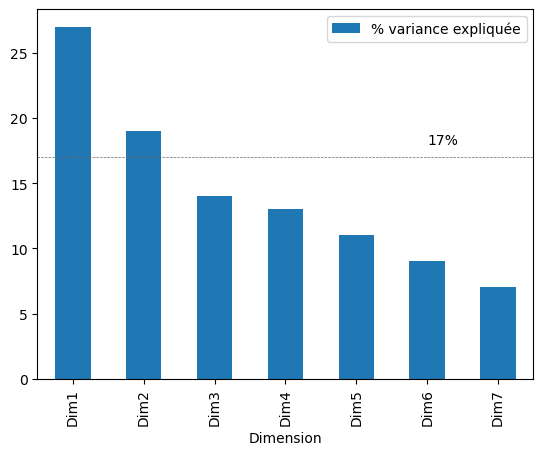

  Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0      Dim1            1.916905                  27.0                   27.0
1      Dim2            1.322804                  19.0                   46.0
2      Dim3            1.001958                  14.0                   61.0
3      Dim4            0.902707                  13.0                   73.0
4      Dim5            0.785241                  11.0                   85.0
5      Dim6            0.595695                   9.0                   93.0
6      Dim7            0.476712                   7.0                  100.0


In [126]:
prop_all_1_pca = pca_pipeline(dataset_all_1_prop, features, 7)
eig_prop_all_1_pca = eigein_values(prop_all_1_pca, plot=True)
coord = coord_pca(dataset_all_1_prop[features], prop_all_1_pca)

In [127]:
plot_ind_pca(dataset_all_1_prop[features], prop_all_1_pca, nbre_dim=3)

               id     COR_1     COR_2
0   prairies_prop  0.561434 -0.559856
1  ombres_13_prop -0.434537  0.210705
2   arbustes_prop  0.492966 -0.590122
3     arbres_prop  0.446522  0.454000
4   C_wavg_scaled -0.762390 -0.205362
5       eaux_prop  0.410352  0.562480
6           canop  0.469358  0.227308


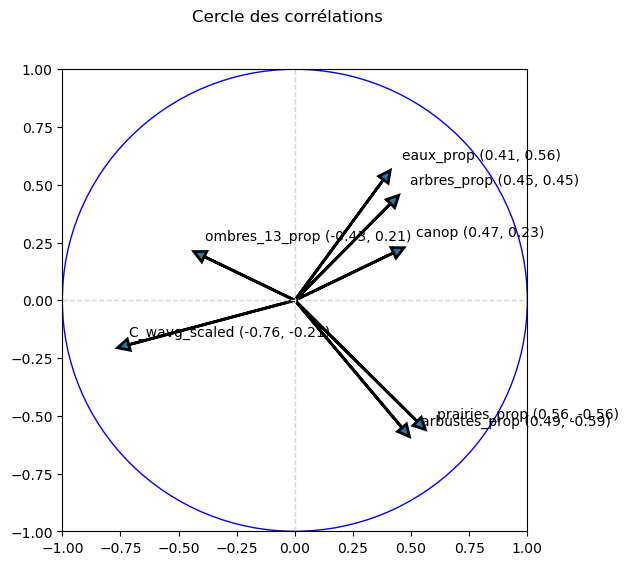

In [128]:
print(coord_var_pca(dataset_all_1_prop[features], prop_all_1_pca, dim=[1,2]))
plot_var_circle(coord_var_pca(dataset_all_1_prop[features], prop_all_1_pca, dim=[1,2]))

Température anti corrélée notamment à la première dimension
Prairies et arbustes anticorrélée avec deuxième et corrélée avec première dimension

               id     COR_1     COR_2
0   prairies_prop  0.561434  0.198326
1  ombres_13_prop -0.434537 -0.233415
2   arbustes_prop  0.492966 -0.352432
3     arbres_prop  0.446522 -0.571023
4   C_wavg_scaled -0.762390  0.103089
5       eaux_prop  0.410352  0.247460
6           canop  0.469358  0.411168


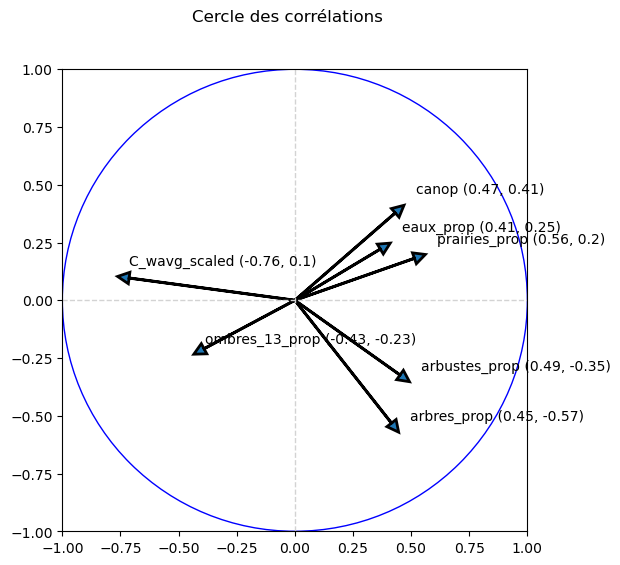

In [129]:
print(coord_var_pca(dataset_all_1_prop[features], prop_all_1_pca, dim=[1,5]))
plot_var_circle(coord_var_pca(dataset_all_1_prop[features], prop_all_1_pca, dim=[1,5]))

ACP sur les segments les plus fréquentés afin de les caractériser en fonctions des variables

In [ ]:
prop_all_1_pca = pca_pipeline(dataset_all_1_prop, features, 7)
eig_prop_all_1_pca = eigein_values(prop_all_1_pca, plot=True)
coord = coord_pca(dataset_all_1_prop[features], prop_all_1_pca)

## Analyse avec les poids : P1O8At2Ar10C6E7Ca8
Prairie : 1
Ombre : 8
Arbustes : 2
Arbres : 10
Température : 6
Eau : 7
Canop : 8

In [130]:
data_set_P1O8At2Ar10C6E7Ca8_path = "./output_data/analyse/P1O8At2Ar10C6E7Ca8/dataset_P1O8At2Ar10C6E7Ca8.gpkg"
data_set_P1O8At2Ar10C6E7Ca8 = gpd.read_file(data_set_P1O8At2Ar10C6E7Ca8_path)

data_set_P1O8At2Ar10C6E7Ca8 = data_set_P1O8At2Ar10C6E7Ca8.set_index(["uniqId"])

In [160]:
graph_P1O8At2Ar10C6E7Ca8_path = "./output_data/network/graph/final_network_P1O8At2Ar10C6E7Ca8.gpkg"
graph_P1O8At2Ar10C6E7Ca8 = gpd.read_file(graph_P1O8At2Ar10C6E7Ca8_path, layer="edges")
print(graph_P1O8At2Ar10C6E7Ca8.columns)
graph_P1O8At2Ar10C6E7Ca8 = graph_P1O8At2Ar10C6E7Ca8.set_index(["uniqId"])

graph_P1O8At2Ar10C6E7Ca8_sample = graph_P1O8At2Ar10C6E7Ca8.loc[data_set_P1O8At2Ar10C6E7Ca8.index.unique().to_list()]

Index(['u', 'v', 'key', 'osmid', 'oneway', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'from', 'to', 'lanes', 'width', 'service',
       'access', 'bridge', 'ref', 'junction', 'tunnel', 'est_width', 'area',
       'uniqId', 'total_score_08', 'total_score_13', 'total_score_18',
       'score_distance_08', 'score_distance_13', 'score_distance_18',
       'freshness_score', 'geometry'],
      dtype='object')


In [141]:
all_it_P1O8At2Ar10C6E7Ca8_path = "./output_data/analyse/P1O8At2Ar10C6E7Ca8/mean_score_P1O8At2Ar10C6E7Ca8.csv"

it_if_P1O8At2Ar10C6E7Ca8, it_len_P1O8At2Ar10C6E7Ca8 = len_if_group(all_it_P1O8At2Ar10C6E7Ca8_path)

print(f"Test de student : {test_students(it_len_P1O8At2Ar10C6E7Ca8['score'], it_if_P1O8At2Ar10C6E7Ca8['score'], alternative='greater')}")
print(f"D de cohen : {d_cohen(it_len_P1O8At2Ar10C6E7Ca8['score'], it_if_P1O8At2Ar10C6E7Ca8['score'])}")

print(f"Coût de distance : ", distance_cost(it_len_P1O8At2Ar10C6E7Ca8, it_if_P1O8At2Ar10C6E7Ca8))

Test de student : TtestResult(statistic=26.611553598616936, pvalue=3.0162436271673836e-129, df=1559)
D de cohen : 0.3652085997321483
Coût de distance :  1.2


alternative = "greater" : L'hypothèse alternative est la suivante : la moyenne de la distribution du score des itinéraires les plus courts est plus grande que celle des itinéraires les plus frais. 
La p-value est < 5% donc on peut rejetter H0.

On double le coût de distance par rapport à des poids mis tous à 1.

In [135]:
print(it_if_P1O8At2Ar10C6E7Ca8.head())

                    Unnamed: 0  score  total_length
id_it type zone_id                                 
0     IF   zone_23           0  35.84       1278.97
           zone_24           1  34.40       3700.36
           zone_25           2  33.15       1313.02
           zone_26           3  34.84       1508.49
           zone_28           4  32.77        737.58


#### Comparaison entre les distributions des scores de fraîcheur, courts et global (segments les plus fréquentés)

In [161]:
max_score_graph = np.max(graph_P1O8At2Ar10C6E7Ca8_sample["total_score_13"])
graph_P1O8At2Ar10C6E7Ca8_sample["score_10"] = graph_P1O8At2Ar10C6E7Ca8_sample["total_score_13"].apply(lambda x: convert_score_on_ten(x, max_score_graph))

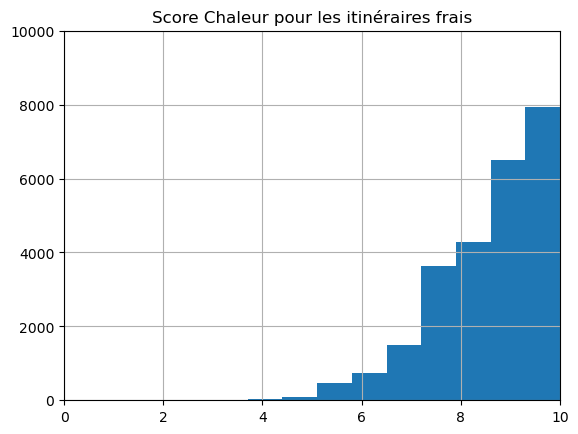

In [168]:
graph_P1O8At2Ar10C6E7Ca8_sample["score_10"].hist()
plt.xlim([0,10])
plt.ylim([0,10000])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

In [172]:
data_set_P1O8At2Ar10C6E7Ca8_if = data_set_P1O8At2Ar10C6E7Ca8.loc[data_set_P1O8At2Ar10C6E7Ca8.index.unique().to_list()]
data_set_P1O8At2Ar10C6E7Ca8_if = data_set_P1O8At2Ar10C6E7Ca8_if[data_set_P1O8At2Ar10C6E7Ca8_if["type"] == "IF"]
print(data_set_P1O8At2Ar10C6E7Ca8_if.columns)

Index(['u', 'v', 'key', 'type', 'id_it', 'osmid', 'length', 'from', 'to',
       'total_score_08', 'total_score_13', 'total_score_18', 'freshness_score',
       'score_distance_08', 'score_distance_13', 'score_distance_18',
       'zone_id', 'geometry'],
      dtype='object')


In [173]:
data_set_P1O8At2Ar10C6E7Ca8_if["score_10"] = data_set_P1O8At2Ar10C6E7Ca8_if["total_score_13"].apply(lambda x: convert_score_on_ten(x, max_score_graph))

In [175]:
len(data_set_P1O8At2Ar10C6E7Ca8_if)

70900

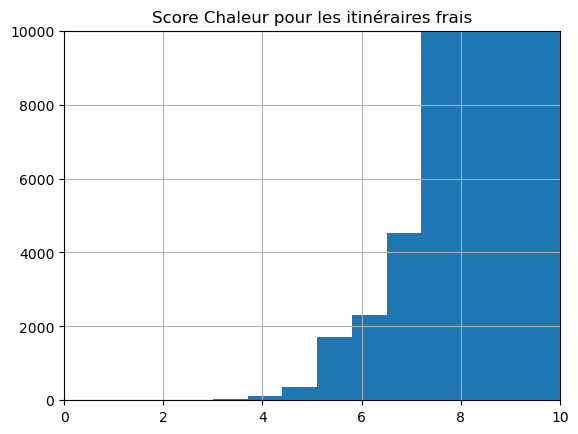

In [174]:
data_set_P1O8At2Ar10C6E7Ca8_if["score_10"].hist()
plt.xlim([0,10])
plt.ylim([0,10000])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

#### Comparaison entre les distributions des scores (itinéraires)

In [147]:
max_score_if = np.max(it_if_P1O8At2Ar10C6E7Ca8["score"])
it_if_P1O8At2Ar10C6E7Ca8["score_10"] = it_if_P1O8At2Ar10C6E7Ca8["score"].apply(lambda x: convert_score_on_ten(x, max_score_if))

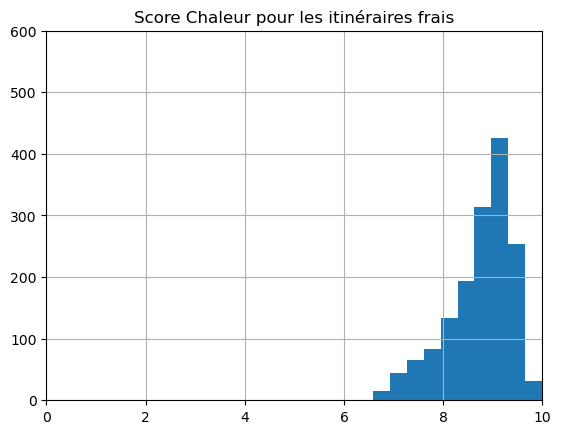

In [148]:
it_if_P1O8At2Ar10C6E7Ca8["score_10"].hist()
plt.xlim([0,10])
plt.ylim([0,600])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

In [149]:
max_score_len = np.max(it_if_P1O8At2Ar10C6E7Ca8["score"])
it_len_P1O8At2Ar10C6E7Ca8["score_10"] = it_len_P1O8At2Ar10C6E7Ca8["score"].apply(lambda x: convert_score_on_ten(x, max_score_len))

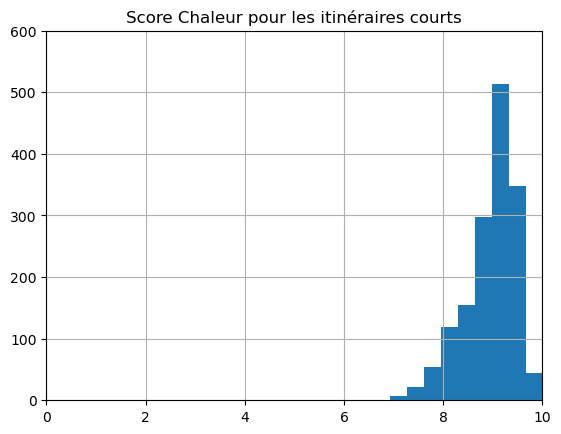

In [152]:
it_len_P1O8At2Ar10C6E7Ca8["score_10"].hist()
plt.xlim([0,10])
plt.ylim([0,600])
plt.title("Score Chaleur pour les itinéraires courts")
plt.show()

## Analyse P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01
Praire : 0.01, Ombre : 0.01, Arbustes : 0.01, Arbres : 10, Température : 0.01, Eau : 0.01, Canopé : 0.01.

Les individus statistiques sont bien les itinéraires, que l'on va pouvoir comparer en fonction du traitement que l'on applique (pondération)
On va chercher à caractériser chacun des itinéraires en fonction de leur proportion en telle ou telle données

In [19]:
data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01 = pd.read_csv("./output_data/analyse/P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01/mean_value_by_itP0_01O0_01At0_01Ar10C0_01E0_01Ca0_01.csv")

In [20]:
print(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01.columns)

Index(['id_it', 'type', 'mean_prairies_prop', 'mean_arbustes_prop',
       'mean_arbres_prop', 'mean_C_wavg_scaled', 'mean_eaux_prop',
       'mean_canop', 'mean_ombres_08_prop', 'mean_ombres_13_prop',
       'mean_ombres_18_prop', 'total_length', 'mean_score', 'score_10'],
      dtype='object')


In [31]:
np.max(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01[data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01["type"] == "LEN"]["total_length"])

3999.88

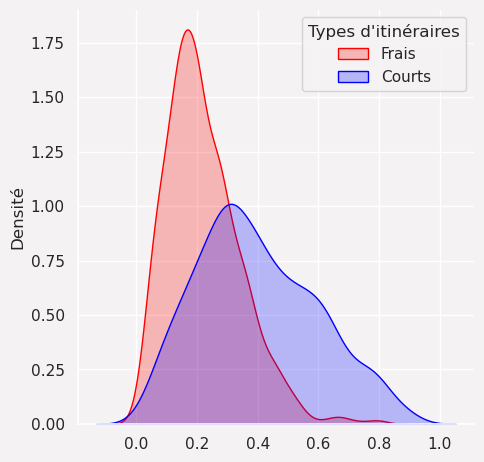

In [32]:
arbres = data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01["mean_arbres_prop"]
sns.set(rc={'axes.facecolor':'#f4f2f2', 'figure.facecolor':'#f4f2f2'})
colour_palette = {"IF": "blue", "LEN": "red"}
legend = {"IF": "Frais", "LEN": "Courts"}
sns.displot(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01, x="mean_arbres_prop", kind="kde", hue="type", fill=True, legend=False, palette=colour_palette)

plt.ylabel("Densité")
plt.xlabel("")

plt.legend(title="Types d'itinéraires", labels=legend.values())
plt.show()

In [21]:
arbres_if = data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01[data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01["type"] == "IF"]["mean_arbres_prop"]
arbres_len = data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01[data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01["type"] == "LEN"]["mean_arbres_prop"]

basic_stats_arbres = pd.DataFrame({
    "mean_if": np.mean(arbres_if),
    "mean_len": np.mean(arbres_len),

    "var_if": np.var(arbres_if),
    "var_len": np.var(arbres_len),

    "quantiles_arbres_if": np.quantile(arbres_if, q=[0.25,0.5,0.75]),
    "quantiles_arbres_len": np.quantile(arbres_len, q=[0.25,0.5,0.75])
})

print(basic_stats_arbres)

    mean_if  mean_len    var_if   var_len  quantiles_arbres_if  \
0  0.398025  0.220245  0.038378  0.014915                 0.25   
1  0.398025  0.220245  0.038378  0.014915                 0.37   
2  0.398025  0.220245  0.038378  0.014915                 0.54   

   quantiles_arbres_len  
0                  0.13  
1                  0.20  
2                  0.29  


In [40]:
all_percent_diff = []
for i, l in zip(arbres_if, arbres_len):
    # print(i)
    percent = round(((i - l)/(l))*100, 2)
    # print(f"dist if : {i}\n dist len : {l}\n percent diff : {percent}")
    all_percent_diff.append(percent)

mean_percent_diff = np.mean(all_percent_diff)
print(f"final mean : {mean_percent_diff}")
quantile_percent_diff = np.quantile(all_percent_diff, q=[0.25,0.5,0.75])
print(quantile_percent_diff)

final mean : 113.9019509202454
[ 19.175  72.    150.805]


In [8]:
max_arbres_len = np.max(arbres_len)
max_arbres_if = np.max(arbres_if)
print(max_arbres_len)
print(max_arbres_if)

0.8
0.9


In [17]:
count = 0
for it in np.array(arbres_if):
    if(it > 0.22):
        count+=1
print(count)
percent = (count/len(arbres_if)*100)
print(percent)

649
79.6319018404908


In [19]:
print(np.min(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01["mean_score"]))
print(np.max(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01["mean_score"]))

1.02
9.94


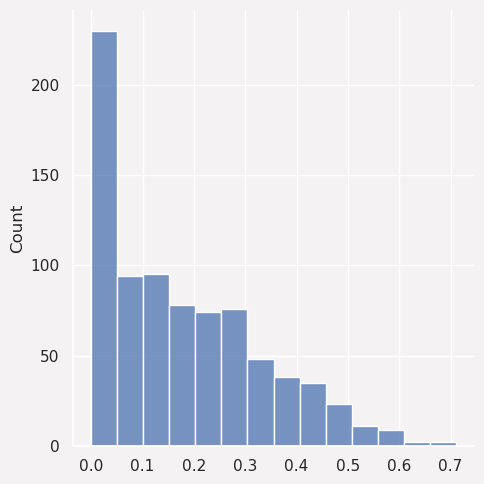

In [65]:
diff = np.array(arbres_if) - np.array(arbres_len)
sns.displot(diff)

In [52]:
test_students(arbres_len, arbres_if)

TtestResult(statistic=-33.289557938606265, pvalue=4.833915109167011e-154, df=814)

In [70]:
d_cohen(arbres_len, arbres_if)

-1.0879388363473599

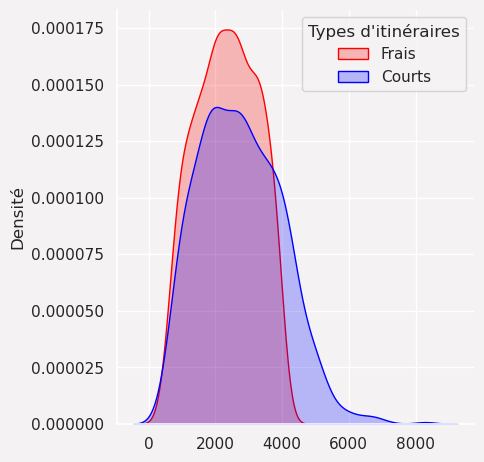

In [39]:
sns.set(rc={'axes.facecolor':'#f4f2f2', 'figure.facecolor':'#f4f2f2'})
colour_palette = {"IF": "blue", "LEN": "red"}
legend = {"IF": "Frais", "LEN": "Courts"}
sns.displot(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01, x="total_length", kind="kde", hue="type", fill=True, legend=False, palette=colour_palette)

plt.ylabel("Densité")
plt.xlabel("")

plt.legend(title="Types d'itinéraires", labels=legend.values())
plt.show()

In [21]:
len_if = data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01[data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01["type"] == "IF"]["total_length"]
len_len = data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01[data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01["type"] == "LEN"]["total_length"]

basic_stats_len = pd.DataFrame({
    "mean_if": np.mean(len_if),
    "mean_len": np.mean(len_len),

    "var_if": np.var(len_if),
    "var_len": np.var(len_len),

    "quantiles_len_if": np.quantile(len_if, q=[0.25,0.5,0.75]),
    "quantiles_len_len": np.quantile(len_len, q=[0.25,0.5,0.75])
})

print(basic_stats_len)

      mean_if     mean_len        var_if        var_len  quantiles_len_if  \
0  2740.31535  2329.336454  1.532347e+06  836856.637548          1782.935   
1  2740.31535  2329.336454  1.532347e+06  836856.637548          2660.900   
2  2740.31535  2329.336454  1.532347e+06  836856.637548          3646.220   

   quantiles_len_len  
0           1586.370  
1           2346.710  
2           3105.335  


In [34]:
if_it = data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01[data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01["type"] == "IF"]["total_length"]

In [46]:
total = 0
m = np.mean(if_it)
for it in if_it:
    if(it > 7000): 
        print(it)
    print((it - m)**2)
    total += (it - m)**2

var = total / len(if_it)
print(var)
print(m)

2655483.2289208886
977004.44052322
1478182.6483427293
2025997.3861143854
2038169.2475494787
860525.8948075145
82182.35512849648
1830650.5365055515
1152326.3554581904
1437014.3884181895
12562.968834386142
611515.633108374
27071.881298680455
17562.782938926044
2506634.1725183125
1099781.443575
279243.1796448157
927995.729361625
364979.5207489873
9934313.811246287
1443855.4164114408
14169.247973649904
191200.98604236127
45554.349951564065
23459.624346655957
4625275.420157207
619660.7747716863
3351296.448689725
2236384.611124081
17844.858797576337
2446892.6110062874
22238.369921134497
187588.30031033698
2959241.656908989
1393284.3150867792
978151.3619288644
1219578.6513891097
225496.43611095048
300014.0133035885
1227275.4558272695
310221.5401659195
104216.20640457018
2889029.8924673917
4496243.106221504
1116307.7290848156
2152982.9368118094
1446714.970806534
4178772.6523357383
2755183.8547309497
51526.57126788306
3164.58568113459
5807.255321870711
15300.539535735774
4736957.889208373
35940

In [36]:
len_it = data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01[data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01["type"] == "LEN"]["total_length"]

In [37]:
all_percent_diff = []
for i, l in zip(if_it, len_it):
    print(i)
    percent = round(((i - l)/(l))*100, 2)
    print(f"dist if : {i}\n dist len : {l}\n percent diff : {percent}")
    all_percent_diff.append(percent)

mean_percent_diff = np.mean(all_percent_diff)
print(f"final mean : {mean_percent_diff}")

1110.75
dist if : 1110.75
 dist len : 1110.75
 percent diff : 0.0
1751.88
dist if : 1751.88
 dist len : 1675.82
 percent diff : 4.54
1524.51
dist if : 1524.51
 dist len : 1295.27
 percent diff : 17.7
1316.94
dist if : 1316.94
 dist len : 1316.94
 percent diff : 0.0
4167.96
dist if : 4167.96
 dist len : 3740.28
 percent diff : 11.43
1812.67
dist if : 1812.67
 dist len : 1659.87
 percent diff : 9.21
3026.99
dist if : 3026.99
 dist len : 2811.43
 percent diff : 7.67
1387.3
dist if : 1387.3
 dist len : 1344.9
 percent diff : 3.15
3813.78
dist if : 3813.78
 dist len : 3281.81
 percent diff : 16.21
1541.56
dist if : 1541.56
 dist len : 1541.56
 percent diff : 0.0
2852.4
dist if : 2852.4
 dist len : 2808.67
 percent diff : 1.56
3522.31
dist if : 3522.31
 dist len : 2687.98
 percent diff : 31.04
2575.78
dist if : 2575.78
 dist len : 2378.16
 percent diff : 8.31
2872.84
dist if : 2872.84
 dist len : 2872.84
 percent diff : 0.0
1157.08
dist if : 1157.08
 dist len : 1157.08
 percent diff : 0.0
37

In [47]:
np.max(all_percent_diff)

255.71

In [67]:
print(np.quantile(all_percent_diff, q=[0.25, 0.5, 0.75, 0.85, 0.9, 0.92, 0.985]))

[ 1.575   8.75   21.84   33.284  46.848  50.3056 95.1096]


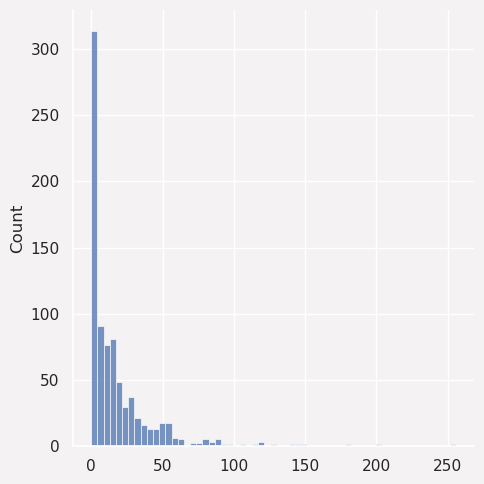

In [35]:
sns.displot(all_percent_diff)

In [57]:
huge_if_len = len_if[len_if > 4000]
print(round((len(huge_if_len)/len(len_if))*100,2))

16.32


In [43]:
def sns_plot(data, variable):
    sns.set(rc={'axes.facecolor':'#f4f2f2', 'figure.facecolor':'#f4f2f2'})
    colour_palette = {"IF": "blue", "LEN": "red"}
    legend = {"IF": "Frais", "LEN": "Courts"}
    sns.displot(data, x=variable, kind="kde", hue="type", fill=True, legend=False, palette=colour_palette)

    plt.ylabel("Densité")
    plt.xlabel("")

    plt.legend(title="Types d'itinéraires", labels=legend.values())
    plt.show()

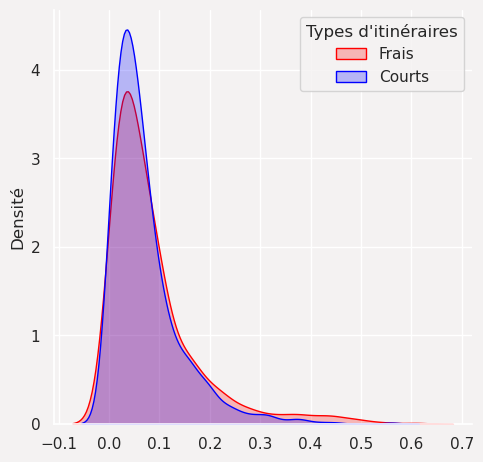

In [45]:
sns_plot(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01, "mean_ombres_13_prop")

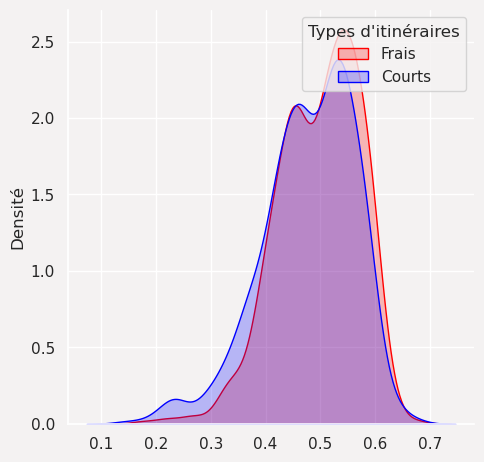

In [46]:
sns_plot(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01, "mean_C_wavg_scaled")

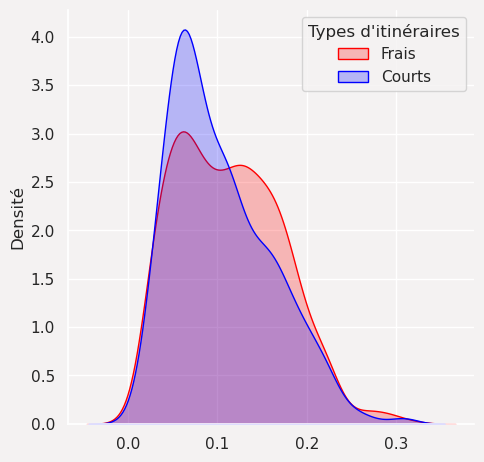

In [47]:
sns_plot(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01, "mean_prairies_prop")

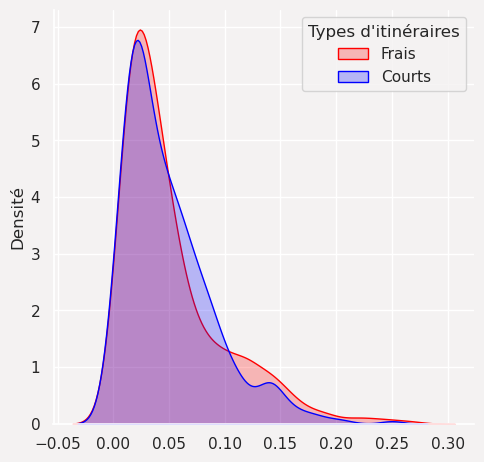

In [48]:
sns_plot(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01, "mean_arbustes_prop")

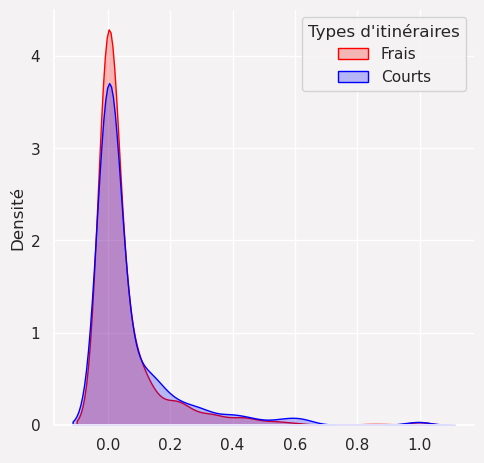

In [49]:
sns_plot(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01, "mean_eaux_prop")

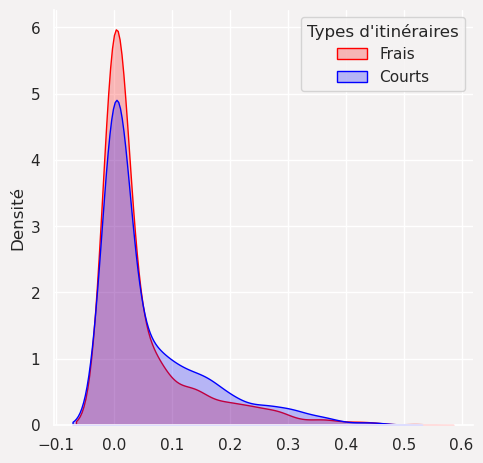

In [51]:
sns_plot(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01, "mean_canop")

## Analyse P0_01O10At0_01Ar10_01C0_01E0_01Ca0_01
Praire : 0.01, Ombre : 10, Arbustes : 0.01, Arbres : 0.01, Température : 0.01, Eau : 0.01, Canopé : 0.01.

In [20]:
data_set_prop_csv_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01 = pd.read_csv("./output_data/analyse/P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01/13h/mean_value_by_itP0_01O10At0_01Ar0_01C0_01E0_01Ca0_01.csv")

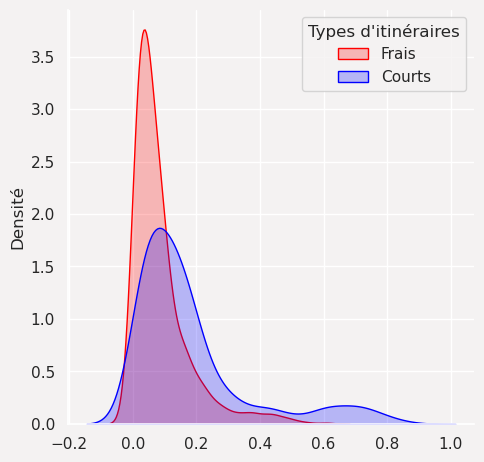

In [21]:
sns_plot(data_set_prop_csv_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01, "mean_ombres_13_prop")

In [22]:
it_if_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01 = data_set_prop_csv_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01[data_set_prop_csv_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["type"] == "IF"]
it_len_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01 = data_set_prop_csv_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01[data_set_prop_csv_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["type"] == "LEN"]

it_if_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01_ombre_13 = it_if_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"]
it_len_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01_ombre_13 = it_len_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"]

test_students(it_len_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01_ombre_13, it_if_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01_ombre_13)

TtestResult(statistic=-20.88583421125668, pvalue=6.684541169192255e-78, df=814)

In [23]:
print(f"IF : {basic_stats(it_if_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01_ombre_13)}")
print(f"LEN : {basic_stats(it_len_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01_ombre_13)}")

IF :        mean       var  quantiles
0  0.179975  0.034315       0.06
1  0.179975  0.034315       0.12
2  0.179975  0.034315       0.21
LEN :        mean       var  quantiles
0  0.086221  0.008556       0.03
1  0.086221  0.008556       0.06
2  0.086221  0.008556       0.11


## Analyse P0_01O0_01At0_01Ar0_01C0_01E0_01Ca10
Praire : 0.01, Ombre : 0-01, Arbustes : 0.01, Arbres : 0_01, Température : 0.01, Eau : 0.01, Canopé : 10.

In [5]:
data_set_prop_csv_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10= pd.read_csv("./output_data/analyse/P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10/13h/mean_value_by_itP0_01O0_0At0_01Ar0_01C0_01E0_01Ca10.csv")

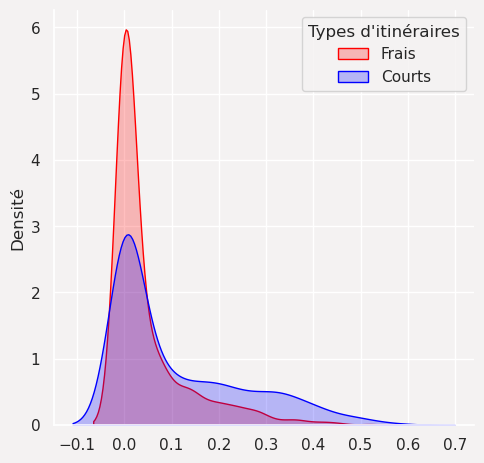

In [25]:
sns_plot(data_set_prop_csv_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10, "mean_canop")

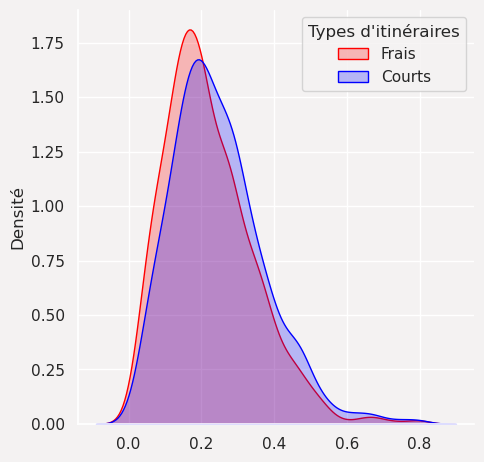

In [26]:
sns_plot(data_set_prop_csv_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10, "mean_arbres_prop")

In [6]:
it_if_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10 = data_set_prop_csv_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10[data_set_prop_csv_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10["type"] == "IF"]
it_len_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10 = data_set_prop_csv_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10[data_set_prop_csv_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10["type"] == "LEN"]

it_if_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10_canop = it_if_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10["mean_canop"]
it_len_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10_canop = it_len_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10["mean_canop"]

print("IF : ", basic_stats(it_if_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10_canop))
print("LEN : ", basic_stats(it_len_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10_canop))

IF :         mean       var  quantiles
0  0.109325  0.019449       0.00
1  0.109325  0.019449       0.04
2  0.109325  0.019449       0.20
LEN :         mean       var  quantiles
0  0.047104  0.007047       0.00
1  0.047104  0.007047       0.00
2  0.047104  0.007047       0.06


In [28]:
test_students(it_len_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10_canop, it_if_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10_canop)

TtestResult(statistic=-18.447989128180943, pvalue=9.258401292919482e-64, df=814)

In [29]:
d_cohen(it_len_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10_canop, it_if_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10_canop)

-0.5400124258784554

% des itinéraires courts et frais ayant un indice de canopé moyen supérieur à 50%

In [18]:
count = 0
for it in it_if_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10_canop:
    if it >= 0.5:
        count+=1
print((count/len(it_if_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10_canop))*100)

1.1042944785276074


Taux de passage par parcs 
Les parcs ne sont pas traités comme les autres données car il s'agit non pas d'un taux de recouvrement mais de la présence ou non d'un parc dans l'itinéraire. 
Pour identifier la présence d'un parc, on regarde l'indice de canopé de chaque segment. Celui-ci est nul si le segment ne passe pas dans un parc et il a la valeur de l'indice de canopé du parc sinon. 

On considère que ce sont les parcs avec un indice de canopé supérieur à 50% qui sont intéressant (encore une valeur arbitraire mais qui peut être soumise à discussion). 
Ainsi, on regarde pour chaque couple d'itinéraire frais et court la distance parcourue dans des parcs et on compare les deux ce qui nous permet de savoir dans quelle mesure nous favorisons ou non les parcs. 

In [103]:
def distance_canop(key, all_edges, printed=True):
    all_it = gpd.read_file(f"./output_data/analyse/{key}/13h/dataset_{key}.gpkg")
    all_it = all_it.set_index(["uniqId"])
    all_edges = all_edges.set_index(["uniqId"])

    all_edges_sample = all_edges.loc[all_it.index.to_list()]
    
    all_it["canop"] = all_edges_sample["canop"]
    prop_distance_canop = all_it.groupby(["type", "id_it"]).apply(lambda x: round((sum(x[x["canop"] >= 0.5]["length"])/sum(x["length"]))*100, 2)).reset_index(name="dist_canop")

    prop_distance_canop_if = prop_distance_canop[prop_distance_canop["type"] == "IF"]
    prop_ditance_canop_len = prop_distance_canop[prop_distance_canop["type"] == "LEN"]

    if(printed):
        print("##MEAN##")
        print("IF: ", np.mean(prop_distance_canop_if["dist_canop"]))
        print("LEN : ", np.mean(prop_ditance_canop_len["dist_canop"]))
        print("##QUANTILES##")
        print("IF : ", np.quantile(prop_distance_canop_if["dist_canop"], q=[0.25,0.5,0.75,0.95]))
        print("LEN : ", np.quantile(prop_ditance_canop_len["dist_canop"], q=[0.25,0.5,0.75,0.95]))
    

In [9]:
all_it_canop = gpd.read_file("./output_data/analyse/P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10/13h/dataset_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10.gpkg")

In [10]:
all_it_canop.columns

Index(['u', 'v', 'key', 'type', 'id_it', 'osmid', 'uniqId', 'length', 'from',
       'to', 'total_score_08', 'total_score_13', 'total_score_18',
       'freshness_score', 'score_distance_08', 'score_distance_13',
       'score_distance_18', 'zone_id', 'geometry'],
      dtype='object')

In [11]:
all_edges_prop = gpd.read_file("output_data/analyse/edges_all_prop.gpkg")
all_edges_prop.set_index(["uniqId"])
all_it_canop.set_index(["uniqId"])

all_edges_prop_sample = all_edges_prop.loc[all_it_canop.index.to_list()]

In [12]:
all_it_canop["canop"] = all_edges_prop_sample["canop"]

In [13]:
distance_canop = all_it_canop.groupby(["type", "id_it"]).apply(lambda x: sum(x[x["canop"] >= 0.5]["length"])).reset_index(name="dist_canop")

In [14]:
distance_canop

,type,id_it,dist_canop
0,IF,0,0.000
1,IF,1,0.000
2,IF,4,0.000
3,IF,5,45.160
4,IF,6,43.173
...,...,...,...
1625,LEN,995,0.000
1626,LEN,996,0.000
1627,LEN,997,0.000
1628,LEN,998,0.000


In [15]:
distance_canop_if = distance_canop[distance_canop["type"] == "IF"]["dist_canop"]
distance_canop_len = distance_canop[distance_canop["type"] == "LEN"]["dist_canop"]

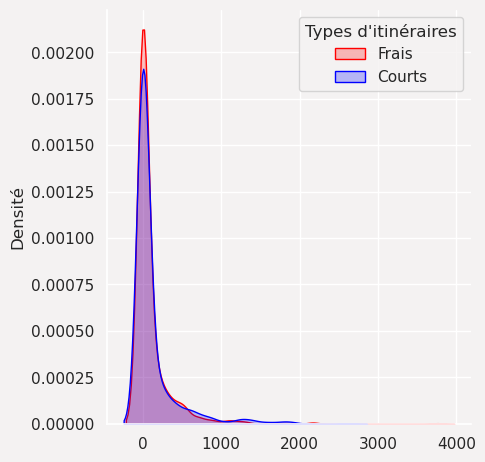

In [16]:
sns_plot(distance_canop, "dist_canop")

In [68]:
print(np.quantile(distance_canop_if, q=[0.25,0.5,0.75]))
print(np.quantile(distance_canop_len, q=[0.25,0.5,0.75]))

[ 0.     0.    66.379]
[ 0.     0.    64.674]


In [8]:
def compare_gain(it_if, it_len, printed=True, q=[0.25,0.5,0.75]):
    all_percent_diff = []
    for i, l in zip(it_if, it_len):
        percent = round(((i - l)/(l+0.000001))*100, 2)
        all_percent_diff.append(percent)
    
    if(printed):
        print("Gain quantiles : ", np.quantile(all_percent_diff, q=q))
        print("Gain mean : ", np.mean(all_percent_diff))
    return all_percent_diff

In [70]:


all_percent_diff_canop = []
for i, l in zip(distance_canop_if, distance_canop_len):
    # print(i)
    percent = round(((i - l)/(l+0.000001))*100, 2)
    # print(f"dist if : {i}\n dist len : {l}\n percent diff : {percent}")
    all_percent_diff_canop.append(percent)

mean_percent_diff_canop = np.mean(all_percent_diff_canop)

In [56]:
gains = compare_gain(distance_canop_if, distance_canop_len)
np.quantile(gains, q=[0.25,0.5,0.75])

array([ 0.  ,  0.  , 16.76])

In [71]:
print(np.quantile(all_percent_diff_canop, q=[0.25,0.5,0.75]))

[ 0.    0.   16.76]


Avec cette pondération, au plus, 25% des itinéraires frais proposés parcourent une distance dans des parcs 16% plus importante que les itinéraires courts. 
Il s'agit du mieux que l'on puisse faire avec ce mode de calcul.

In [63]:
prop_distance_canop = all_it_canop.groupby(["type", "id_it"]).apply(lambda x: round((sum(x[x["canop"] >= 0.5]["length"])/sum(x["length"]))*100, 2)).reset_index(name="dist_canop")

In [64]:
prop_distance_canop_if = prop_distance_canop[prop_distance_canop["type"] == "IF"]
prop_ditance_canop_len = prop_distance_canop[prop_distance_canop["type"] == "LEN"]

In [65]:
prop_distance_canop_if.head()

,type,id_it,dist_canop
0,IF,0,0.00
1,IF,1,0.00
2,IF,4,0.00
3,IF,5,3.43
4,IF,6,1.15


In [80]:
print("IF: ", np.mean(prop_distance_canop_if["dist_canop"]))
print("LEN : ", np.mean(prop_ditance_canop_len["dist_canop"]))

IF:  5.231803680981595
LEN :  4.601987730061349


In [79]:
print("IF : ", np.quantile(prop_distance_canop_if["dist_canop"], q=[0.25,0.5,0.75,0.95]))
print("LEN : ", np.quantile(prop_ditance_canop_len["dist_canop"], q=[0.25,0.5,0.75,0.95]))

IF :  [ 0.     0.     3.18  32.556]
LEN :  [ 0.     0.     2.765 24.232]


In [104]:
distance_canop("P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10", all_edges_prop)

##MEAN##
IF:  9.874245398773008
LEN :  3.6860981595092026
##QUANTILES##
IF :  [ 0.     0.    18.425 41.077]
LEN :  [ 0.     0.     2.9   19.897]


## Analyse P0_01O_01At0_01Ar10C0_01E0_01Ca10
Praire : 0.01, Ombre : 0.01, Arbustes : 0.01, Arbres : 10, Température : 0.01, Eau : 0.01, Canopé : 10

In [4]:
data_set_prop_csv_P0_01O10At0_01Ar10C0_01E0_01Ca10 = pd.read_csv("./output_data/analyse/P0_01O10At0_01Ar10C0_01E0_01Ca10/13h/mean_value_by_itP0_01O10At0_01Ar10C0_01E0_01Ca10.csv")

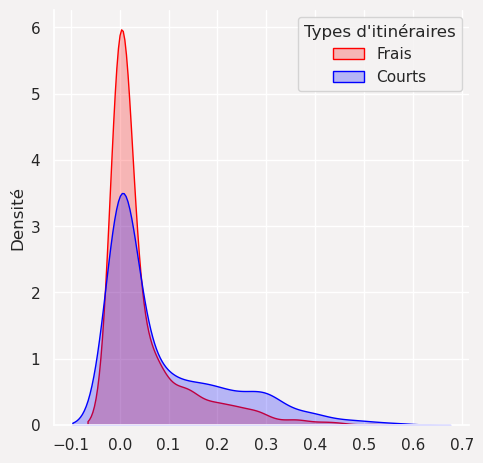

In [5]:
sns_plot(data_set_prop_csv_P0_01O10At0_01Ar10C0_01E0_01Ca10, "mean_canop")
if_it_P0_01O10At0_01Ar10C0_01E0_01Ca10 = data_set_prop_csv_P0_01O10At0_01Ar10C0_01E0_01Ca10[data_set_prop_csv_P0_01O10At0_01Ar10C0_01E0_01Ca10["type"] == "IF"]
if_it_P0_01O10At0_01Ar10C0_01E0_01Ca10_canop = if_it_P0_01O10At0_01Ar10C0_01E0_01Ca10["mean_canop"]

In [6]:
len_it_P0_01O10At0_01Ar10C0_01E0_01Ca10 = data_set_prop_csv_P0_01O10At0_01Ar10C0_01E0_01Ca10[data_set_prop_csv_P0_01O10At0_01Ar10C0_01E0_01Ca10["type"] == "LEN"]

comparaison avec pondération à 10 et arbre 0

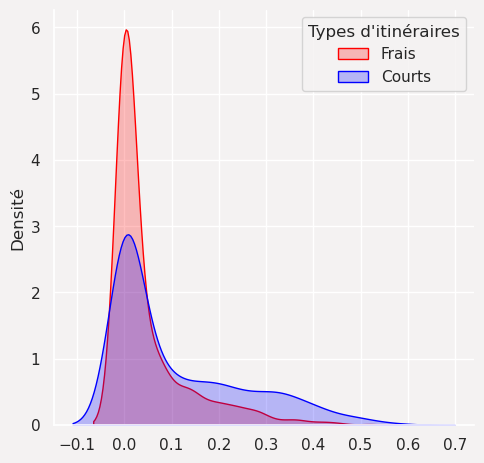

In [ ]:
sns_plot(data_set_prop_csv_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10, "mean_canop")

In [8]:
test_students(it_if_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10_canop, if_it_P0_01O10At0_01Ar10C0_01E0_01Ca10_canop)

TtestResult(statistic=10.246214707497026, pvalue=2.959191100669004e-23, df=814)

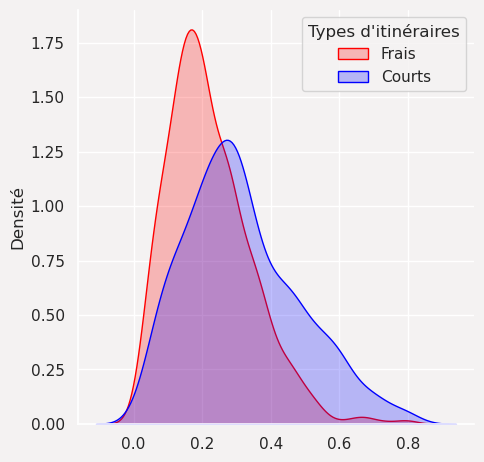

In [74]:
sns_plot(data_set_prop_csv_P0_01O10At0_01Ar10C0_01E0_01Ca10, "mean_arbres_prop")

Comparaison avec la pondération initiale : 

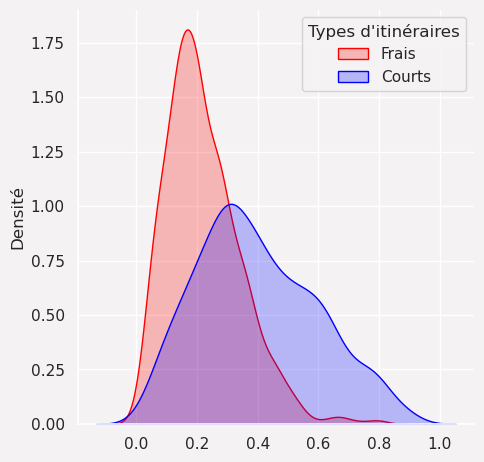

In [76]:
sns_plot(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01, "mean_arbres_prop")

In [22]:
if_it_P0_01O10At0_01Ar10C0_01E0_01Ca10_arbres = if_it_P0_01O10At0_01Ar10C0_01E0_01Ca10["mean_arbres_prop"]
test_students(arbres_if, if_it_P0_01O10At0_01Ar10C0_01E0_01Ca10_arbres)

TtestResult(statistic=20.711402153810177, pvalue=7.182431717139101e-77, df=814)

In [23]:
d_cohen(arbres_if, if_it_P0_01O10At0_01Ar10C0_01E0_01Ca10_arbres)

0.45855722991167475

In [24]:
print("arbres max : ", basic_stats(arbres_if))
print("arbres et parcs 10 : ", basic_stats(if_it_P0_01O10At0_01Ar10C0_01E0_01Ca10_arbres))

arbres max :         mean       var  quantiles
0  0.398025  0.038378       0.25
1  0.398025  0.038378       0.37
2  0.398025  0.038378       0.54
arbres et parcs 10 :         mean       var  quantiles
0  0.314748  0.027468       0.20
1  0.314748  0.027468       0.29
2  0.314748  0.027468       0.42


In [25]:
print("parcs max: ", basic_stats(it_if_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10_canop))
print("parcs 10 et arbres 10 :", basic_stats(if_it_P0_01O10At0_01Ar10C0_01E0_01Ca10_canop))

parcs max:         mean       var  quantiles
0  0.109325  0.019449       0.00
1  0.109325  0.019449       0.04
2  0.109325  0.019449       0.20
parcs 10 et arbres 10 :        mean       var  quantiles
0  0.088466  0.015222       0.00
1  0.088466  0.015222       0.02
2  0.088466  0.015222       0.15


In [105]:
distance_canop("P0_01O10At0_01Ar10C0_01E0_01Ca10", all_edges_prop)

##MEAN##
IF:  8.068233128834356
LEN :  3.6860981595092026
##QUANTILES##
IF :  [ 0.     0.    13.36  37.434]
LEN :  [ 0.     0.     2.9   19.897]


Gain de TR pour les arbres

In [92]:
gains_prop_arbres_init = compare_gain(arbres_if, arbres_len)
# print(np.quantile(gains_prop_arbres_init, q=[0.25,0.5,0.75]))
# print(np.mean(gains_prop_arbres_init))

Gain quantiles :  [ 19.175  72.    150.805]
Gain mean :  113.90090797546013


In [10]:
gains_prop_arbres = compare_gain(if_it_P0_01O10At0_01Ar10C0_01E0_01Ca10_arbres, len_it_P0_01O10At0_01Ar10C0_01E0_01Ca10["mean_arbres_prop"])

NameError: name 'if_it_P0_01O10At0_01Ar10C0_01E0_01Ca10_arbres' is not defined

In [85]:
print(np.quantile(gains_prop_arbres, q=[0.25,0.5,0.75]))
print(np.mean(gains_prop_arbres))

[ 0.   25.71 77.78]
59.45322699386504


ALL : 1, Arbres : 10, Canop : 1

In [11]:
data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca1 = pd.read_csv("./output_data/analyse/P0_01O0_01At0_01Ar10C0_01E0_01Ca1/13h/mean_value_by_itP0_01O0_01At0_01Ar10C0_01E0_01Ca1.csv")

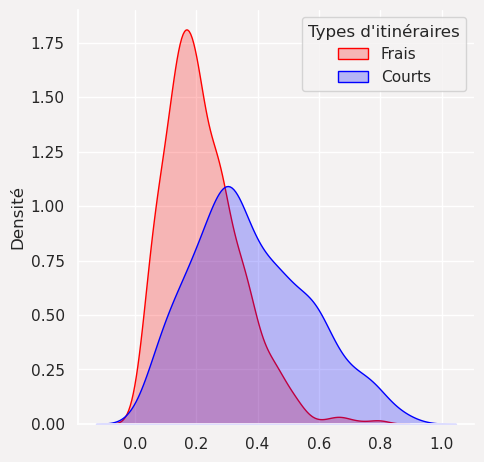

In [31]:
sns_plot(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca1, "mean_arbres_prop")

In [27]:
if_it_P0_01O0_01At0_01Ar10C0_01E0_01Ca1 = data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca1[data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca1["type"] == "IF"]

In [30]:
if_it_P0_01O0_01At0_01Ar10C0_01E0_01Ca1_arbres = if_it_P0_01O0_01At0_01Ar10C0_01E0_01Ca1["mean_arbres_prop"]
test_students(arbres_if, if_it_P0_01O0_01At0_01Ar10C0_01E0_01Ca1_arbres)

TtestResult(statistic=10.227202898428974, pvalue=3.521718979861464e-23, df=814)

In [35]:
wilcoxon(arbres_if, if_it_P0_01O0_01At0_01Ar10C0_01E0_01Ca1_arbres, alternative="greater")

WilcoxonResult(statistic=22766.5, pvalue=9.118400778618534e-36)

In [36]:
print("arbres max : ", basic_stats(arbres_if))
print("arbres et parcs 1 : ", basic_stats(if_it_P0_01O0_01At0_01Ar10C0_01E0_01Ca1_arbres))

arbres max :         mean       var  quantiles
0  0.398025  0.038378       0.25
1  0.398025  0.038378       0.37
2  0.398025  0.038378       0.54
arbres et parcs 10 :         mean       var  quantiles
0  0.376859  0.035104       0.24
1  0.376859  0.035104       0.35
2  0.376859  0.035104       0.51


ALL 0, Arbres: 10, Canop : 9

In [12]:
def print_quantiles_to_compare(key1, key2, column):
    dataset_1 = pd.read_csv(f"./output_data/analyse/{key1}/13h/mean_value_by_it{key1}.csv")
    if_it_1 = dataset_1[dataset_1["type"] == "IF"]

    dataset_2 = pd.read_csv(f"./output_data/analyse/{key2}/13h/mean_value_by_it{key2}.csv")
    if_it_2 = dataset_2[dataset_2["type"] == "IF"]

    print(f"{column}; {key1}", basic_stats(if_it_1[column]))
    print(f"{column}; {key2}", basic_stats(if_it_2[column]))

def print_quantiles_to_compare_spec(key1, column):
    dataset_1 = pd.read_csv(f"./output_data/analyse/{key1}/13h/mean_value_by_it{key1}.csv")
    if_it_1 = dataset_1[dataset_1["type"] == "IF"]

    print(f"{column}; {key1}", basic_stats(if_it_1[column]))
    print(f"{column}; arbres : ", basic_stats(arbres_if))

def gain_compare_key(key, column):
    dataset = pd.read_csv(f"./output_data/analyse/{key}/13h/mean_value_by_it{key}.csv")
    if_it = dataset[dataset["type"] == "IF"]
    if_len = dataset[dataset["type"] == "LEN"]

    all_percent_diff = compare_gain(if_it[column], if_len[column])

    return all_percent_diff



In [40]:
data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca9 = pd.read_csv("./output_data/analyse/P0_01O0_01At0_01Ar10C0_01E0_01Ca9/13h/mean_value_by_itP0_01O0_01At0_01Ar10C0_01E0_01Ca9.csv")
it_if_P0_01O0_01At0_01Ar10C0_01E0_01Ca9 = data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca9[data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca9["type"] == "IF"]
it_if_P0_01O0_01At0_01Ar10C0_01E0_01Ca9_arbres = it_if_P0_01O0_01At0_01Ar10C0_01E0_01Ca9["mean_arbres_prop"]
it_if_P0_01O0_01At0_01Ar10C0_01E0_01Ca9_canop = it_if_P0_01O0_01At0_01Ar10C0_01E0_01Ca9["mean_canop"]

In [38]:
print("arbres max : ", basic_stats(arbres_if))
print("arbres et parcs 9 : ", basic_stats(it_if_P0_01O0_01At0_01Ar10C0_01E0_01Ca9_arbres))

arbres max :         mean       var  quantiles
0  0.398025  0.038378       0.25
1  0.398025  0.038378       0.37
2  0.398025  0.038378       0.54
arbres et parcs 9 :         mean      var  quantiles
0  0.318479  0.02773       0.20
1  0.318479  0.02773       0.30
2  0.318479  0.02773       0.43


In [13]:
gain_ar10_Ca9 = gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca9", "mean_arbres_prop")

Gain quantiles :  [ 0.   28.57 81.82]
Gain mean :  61.67348466257668


In [41]:
print("parcs max: ", basic_stats(it_if_P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10_canop))
print("parcs 10 et arbres 10 :", basic_stats(it_if_P0_01O0_01At0_01Ar10C0_01E0_01Ca9_canop))

parcs max:         mean       var  quantiles
0  0.109325  0.019449       0.00
1  0.109325  0.019449       0.04
2  0.109325  0.019449       0.20
parcs 10 et arbres 10 :        mean       var  quantiles
0  0.086135  0.014672       0.00
1  0.086135  0.014672       0.01
2  0.086135  0.014672       0.15


In [30]:
gain_ar10_Ca9_canop = gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca9", "mean_canop")
quantiles_ar10_ca9_canop = np.quantile(gain_ar10_Ca9_canop, q=[0.25,0.5,0.75])

Gain quantiles :  [ 0.  0. 80.]
Gain mean :  1192699.3229447855


distance parcourue parcs

In [106]:
distance_canop("P0_01O0_01At0_01Ar10C0_01E0_01Ca9", all_edges_prop)

##MEAN##
IF:  7.787582822085889
LEN :  3.6860981595092026
##QUANTILES##
IF :  [ 0.   0.  13.1 37. ]
LEN :  [ 0.     0.     2.9   19.897]


In [48]:
print_quantiles_to_compare_spec("P0_01O0_01At0_01Ar10C0_01E0_01Ca7", "mean_arbres_prop")

mean_arbres_prop; P0_01O0_01At0_01Ar10C0_01E0_01Ca7        mean       var  quantiles
0  0.327902  0.028552       0.20
1  0.327902  0.028552       0.30
2  0.327902  0.028552       0.44
mean_arbres_prop; arbres :         mean       var  quantiles
0  0.398025  0.038378       0.25
1  0.398025  0.038378       0.37
2  0.398025  0.038378       0.54


In [14]:
gain_ar10_Ca7 = gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca7", "mean_arbres_prop")

Gain quantiles :  [ 2.865 32.14  93.725]
Gain mean :  69.21462576687117


In [49]:
print_quantiles_to_compare("P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10", "P0_01O0_01At0_01Ar10C0_01E0_01Ca7", "mean_canop")

mean_canop; P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10        mean       var  quantiles
0  0.109325  0.019449       0.00
1  0.109325  0.019449       0.04
2  0.109325  0.019449       0.20
mean_canop; P0_01O0_01At0_01Ar10C0_01E0_01Ca7        mean       var  quantiles
0  0.084528  0.014486       0.00
1  0.084528  0.014486       0.01
2  0.084528  0.014486       0.14


distance parcourue parcs

In [107]:
distance_canop("P0_01O0_01At0_01Ar10C0_01E0_01Ca7", all_edges_prop)

##MEAN##
IF:  7.669582822085889
LEN :  3.6860981595092026
##QUANTILES##
IF :  [ 0.     0.    12.935 37.072]
LEN :  [ 0.     0.     2.9   19.897]


In [50]:
print_quantiles_to_compare_spec("P0_01O0_01At0_01Ar10C0_01E0_01Ca5", "mean_arbres_prop")

mean_arbres_prop; P0_01O0_01At0_01Ar10C0_01E0_01Ca5        mean       var  quantiles
0  0.338454  0.030023       0.21
1  0.338454  0.030023       0.31
2  0.338454  0.030023       0.45
mean_arbres_prop; arbres :         mean       var  quantiles
0  0.398025  0.038378       0.25
1  0.398025  0.038378       0.37
2  0.398025  0.038378       0.54


comparaison des quantiles des gains pour les arbres

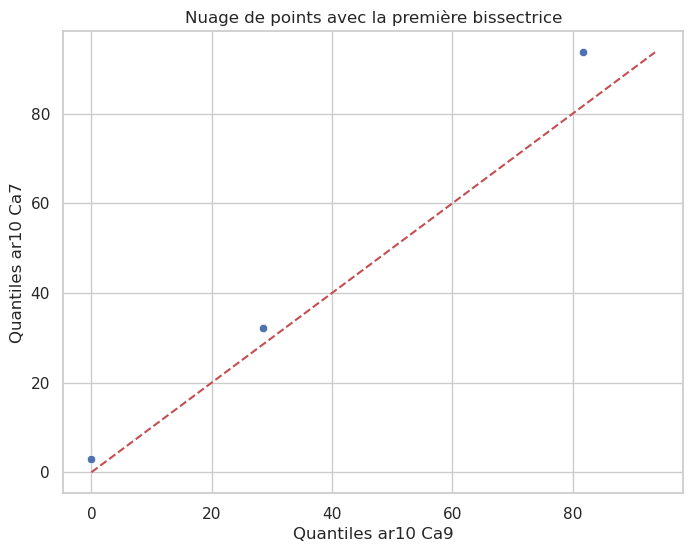

In [16]:
quantiles_ar10_ca9 = np.quantile(gain_ar10_Ca9, q=[0.25,0.5,0.75])
quantiles_ar10_ca7 = np.quantile(gain_ar10_Ca7, q=[0.25,0.5,0.75])

data = {
    "quantiles_ar10_ca9": quantiles_ar10_ca9, 
    "quantiles_ar10_ca7": quantiles_ar10_ca7
}

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x="quantiles_ar10_ca9", y="quantiles_ar10_ca7")

# Tracer la première bissectrice (x=y)
x = np.linspace(min(quantiles_ar10_ca9.min(), quantiles_ar10_ca7.min()),
                max(quantiles_ar10_ca9.max(), quantiles_ar10_ca7.max()))
plt.plot(x, x, color='r', linestyle='--')

# Ajouter des titres et des étiquettes
plt.title("Nuage de points avec la première bissectrice")
plt.xlabel("Quantiles ar10 Ca9")
plt.ylabel("Quantiles ar10 Ca7")

# Afficher le graphique
plt.show()

In [18]:
diff_quantiles_ar10_ca7_9 = quantiles_ar10_ca7 -quantiles_ar10_ca9
print(diff_quantiles_ar10_ca7_9)

[ 2.865  3.57  11.905]


In [19]:
gain_ar10_Ca5 = gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca5", "mean_arbres_prop")

Gain quantiles :  [  4.76  37.5  105.55]
Gain mean :  75.30247852760735


In [51]:
print_quantiles_to_compare("P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10", "P0_01O0_01At0_01Ar10C0_01E0_01Ca5", "mean_canop")

mean_canop; P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10        mean       var  quantiles
0  0.109325  0.019449       0.00
1  0.109325  0.019449       0.04
2  0.109325  0.019449       0.20
mean_canop; P0_01O0_01At0_01Ar10C0_01E0_01Ca5        mean       var  quantiles
0  0.081804  0.014037       0.00
1  0.081804  0.014037       0.01
2  0.081804  0.014037       0.14


distance parcourue parcs

In [108]:
distance_canop("P0_01O0_01At0_01Ar10C0_01E0_01Ca5", all_edges_prop)

##MEAN##
IF:  7.291067484662577
LEN :  3.6860981595092026
##QUANTILES##
IF :  [ 0.     0.    11.985 35.952]
LEN :  [ 0.     0.     2.9   19.897]


In [52]:
print_quantiles_to_compare_spec("P0_01O0_01At0_01Ar10C0_01E0_01Ca3", "mean_arbres_prop")

mean_arbres_prop; P0_01O0_01At0_01Ar10C0_01E0_01Ca3        mean       var  quantiles
0  0.352933  0.032051       0.22
1  0.352933  0.032051       0.33
2  0.352933  0.032051       0.47
mean_arbres_prop; arbres :         mean       var  quantiles
0  0.398025  0.038378       0.25
1  0.398025  0.038378       0.37
2  0.398025  0.038378       0.54


In [21]:
quantiles_ar10_ca5 = np.quantile(gain_ar10_Ca5, q=[0.25,0.5,0.75])

In [22]:
diff_quantiles_ar10_ca5_7 =  quantiles_ar10_ca5 - quantiles_ar10_ca7
print(diff_quantiles_ar10_ca5_7)

[ 1.895  5.36  11.825]


In [24]:
gain_ar10_Ca3 = gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca3", "mean_arbres_prop")

Gain quantiles :  [  7.69  46.15 119.2 ]
Gain mean :  86.53732515337423


In [53]:
print_quantiles_to_compare("P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10", "P0_01O0_01At0_01Ar10C0_01E0_01Ca3", "mean_canop")

mean_canop; P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10        mean       var  quantiles
0  0.109325  0.019449       0.00
1  0.109325  0.019449       0.04
2  0.109325  0.019449       0.20
mean_canop; P0_01O0_01At0_01Ar10C0_01E0_01Ca3        mean       var  quantiles
0  0.076012  0.012569       0.00
1  0.076012  0.012569       0.01
2  0.076012  0.012569       0.12


In [26]:
quantiles_ar10_ca3 = np.quantile(gain_ar10_Ca3, q=[0.25,0.5,0.75])
diff_quantiles_ar10_ca3_5 = quantiles_ar10_ca3-quantiles_ar10_ca5
print(diff_quantiles_ar10_ca3_5)

[ 2.93  8.65 13.65]


distance parcourue parcs

In [109]:
distance_canop("P0_01O0_01At0_01Ar10C0_01E0_01Ca3", all_edges_prop)

##MEAN##
IF:  6.787398773006134
LEN :  3.6860981595092026
##QUANTILES##
IF :  [ 0.     0.    10.54  34.228]
LEN :  [ 0.     0.     2.9   19.897]


difference distance avec la fonction gain

In [122]:
test_if = data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01[data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01["type"] == "IF"]
test_len = data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01[data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01["type"] == "LEN"]
test_diff = compare_gain(test_if["total_length"], test_len["total_length"])

Gain quantiles :  [ 1.575  8.75  21.84 ]
Gain mean :  16.99633128834356


In [123]:
np.quantile(test_diff, q=[0.25,0.5,0.75,0.85,0.92,0.985])

array([ 1.575 ,  8.75  , 21.84  , 33.284 , 50.3056, 95.1096])

In [119]:
distance_sup = gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca3", "total_length")

Gain quantiles :  [ 0.465  3.13  11.1  ]
Gain mean :  7.4931165644171775


In [131]:
np.quantile(distance_sup, q=[0.25,0.5,0.75,0.85,0.967,0.985])

array([ 0.465 ,  3.13  , 11.1   , 15.728 , 33.1521, 42.9479])

In [54]:
print_quantiles_to_compare("P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10", "P0_01O0_01At0_01Ar10C0_01E0_01Ca1", "mean_canop")

mean_canop; P0_01O0_0At0_01Ar0_01C0_01E0_01Ca10        mean       var  quantiles
0  0.109325  0.019449       0.00
1  0.109325  0.019449       0.04
2  0.109325  0.019449       0.20
mean_canop; P0_01O0_01At0_01Ar10C0_01E0_01Ca1        mean       var  quantiles
0  0.066896  0.010004       0.00
1  0.066896  0.010004       0.01
2  0.066896  0.010004       0.11


In [27]:
gain_ar10_Ca1 = gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca1", "mean_arbres_prop")

Gain quantiles :  [ 14.29   58.82  132.665]
Gain mean :  100.29898159509204


In [28]:
quantiles_ar10_ca1 = np.quantile(gain_ar10_Ca1, q=[0.25,0.5,0.75])
diff_quantiles_ar10_ca1_3 = quantiles_ar10_ca1 - quantiles_ar10_ca3
print(diff_quantiles_ar10_ca1_3)

[ 6.6   12.67  13.465]


distance parcourue parcs

In [110]:
distance_canop("P0_01O0_01At0_01Ar10C0_01E0_01Ca1", all_edges_prop)

##MEAN##
IF:  6.034969325153373
LEN :  3.6860981595092026
##QUANTILES##
IF :  [ 0.     0.     8.935 29.015]
LEN :  [ 0.     0.     2.9   19.897]


In [132]:
distance_sup_01 = gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca1", "total_length")

Gain quantiles :  [ 1.015  5.56  15.89 ]
Gain mean :  11.264490797546014


In [135]:
print(np.quantile(distance_sup_01, q=[0.25,0.5,0.75,0.85,0.93,0.985]))

[ 1.015   5.56   15.89   24.047  34.4704 57.9708]


Représentation des pertes de gains. L'objectif est de minimiser au mieux les pertes de gains en TR d'arbres et en indice de canopé / distance parcourue dans les parcs (indic > 50%).

In [195]:
perte_gain_arbre_Canop_9_7 = np.array(gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca7", "mean_arbres_prop")) - np.array(gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca9", "mean_arbres_prop"))

Gain quantiles :  [ 2.865 32.14  93.725]
Gain mean :  69.21462576687117
Gain quantiles :  [ 0.   28.57 81.82]
Gain mean :  61.67348466257668


In [196]:
print(np.quantile(perte_gain_arbre_Canop_9_7, q=[0.25,0.5,0.75]))

[0. 0. 0.]


Gain quantiles :  [ 14.29   58.82  132.665]
Gain mean :  100.29898159509204


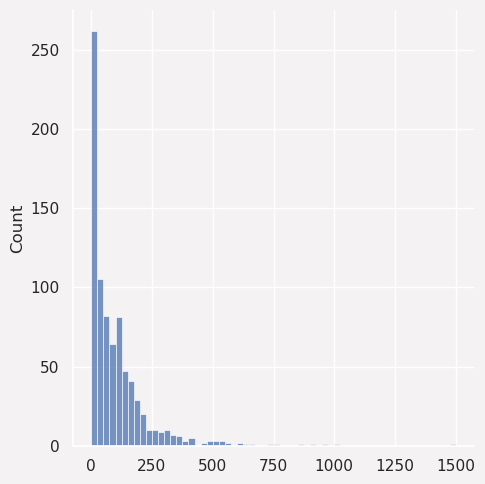

In [202]:
sns.displot(gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca1", "mean_arbres_prop"))

Gain quantiles :  [ 0.   28.57 81.82]
Gain mean :  61.67348466257668


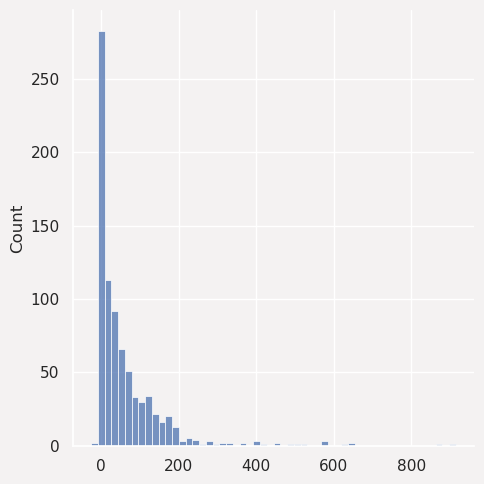

In [206]:
sns.displot(gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca9", "mean_arbres_prop"))

In [240]:
perte_gain_arbre_Canop_7_5 = np.array(gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca7", "mean_canop")) - np.array(gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca9", "mean_canop"))
print(np.quantile(perte_gain_arbre_Canop_7_5, q=[0.25,0.5,0.75,0.9]))
print(np.mean(perte_gain_arbre_Canop_7_5))

Gain quantiles :  [ 0.  0. 75.]
Gain mean :  1157111.1287730061
Gain quantiles :  [ 0.  0. 80.]
Gain mean :  1192699.3229447855
[0. 0. 0. 0.]
-35588.19417177915


In [215]:
test = gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca1", "mean_arbres_prop")
test_2 = gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca9", "mean_arbres_prop")
print(np.quantile(test, q=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
print(np.quantile(test_2, q=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))

Gain quantiles :  [ 14.29   58.82  132.665]
Gain mean :  100.29898159509204
Gain quantiles :  [ 0.   28.57 81.82]
Gain mean :  61.67348466257668
[  0.      8.202  20.     37.704  58.82   88.504 118.944 155.    231.198]
[  0.     0.     5.59  16.13  28.57  44.44  66.67 103.63 157.14]


In [204]:
diff = []
for g_x, g_y in zip(gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca1", "mean_arbres_prop"), gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca3", "mean_arbres_prop")):
    print("CA1 : ", g_x)
    print("CA3 : ", g_y)
    diff.append(g_y-g_x)

print(np.quantile(diff, q=[0.25,0.5,0.75]))

Gain quantiles :  [ 14.29   58.82  132.665]
Gain mean :  100.29898159509204
Gain quantiles :  [  7.69  46.15 119.2 ]
Gain mean :  86.53732515337423
CA1 :  0.0
CA3 :  0.0
CA1 :  12.5
CA3 :  12.5
CA1 :  54.55
CA3 :  54.55
CA1 :  0.0
CA3 :  0.0
CA1 :  64.29
CA3 :  64.29
CA1 :  47.37
CA3 :  0.0
CA1 :  40.0
CA3 :  40.0
CA1 :  21.05
CA3 :  21.05
CA1 :  88.46
CA3 :  88.46
CA1 :  0.0
CA3 :  0.0
CA1 :  18.52
CA3 :  18.52
CA1 :  0.0
CA3 :  0.0
CA1 :  25.0
CA3 :  25.0
CA1 :  0.0
CA3 :  4.35
CA1 :  0.0
CA3 :  0.0
CA1 :  0.0
CA3 :  0.0
CA1 :  19.12
CA3 :  19.12
CA1 :  14.29
CA3 :  14.29
CA1 :  86.67
CA3 :  86.67
CA1 :  160.0
CA3 :  16.0
CA1 :  0.0
CA3 :  0.0
CA1 :  0.0
CA3 :  0.0
CA1 :  17.39
CA3 :  0.0
CA1 :  0.0
CA3 :  0.0
CA1 :  12.9
CA3 :  0.0
CA1 :  0.0
CA3 :  0.0
CA1 :  0.0
CA3 :  0.0
CA1 :  115.38
CA3 :  0.0
CA1 :  31.25
CA3 :  31.25
CA1 :  112.5
CA3 :  0.0
CA1 :  81.48
CA3 :  81.48
CA1 :  114.81
CA3 :  114.81
CA1 :  47.06
CA3 :  47.06
CA1 :  114.71
CA3 :  73.53
CA1 :  115.0
CA3 :  105.0
CA1

## Analyse P0_01010At0_01Ar0_01C0_01E0_01Ca0_01
Praire : 0.01, Ombre : 10, Arbustes : 0.01, Arbres : 0.01, Température : 0.01, Eau : 0.01, Canopé : 0.01.

In [138]:
def load_dataset(key):
    dataset = pd.read_csv(f"./output_data/analyse/{key}/13h/mean_value_by_it{key}.csv")

    if_it = dataset[dataset["type"] == "IF"]
    len_it = dataset[dataset["type"] == "LEN"]

    return dataset, if_it, len_it
    

In [139]:
dataset_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01, if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01, len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01 = load_dataset("P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01")

In [209]:
perte_gain_arbre_ombre_10 = np.array(gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca1", "mean_arbres_prop")) - np.array(gain_compare_key("P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01", "mean_arbres_prop"))
print(np.quantile(perte_gain_arbre_ombre_10, q=[0.25,0.5,0.75]))

Gain quantiles :  [ 14.29   58.82  132.665]
Gain mean :  100.29898159509204
Gain quantiles :  [-14.76   0.     0.  ]
Gain mean :  -3.025693251533743
[ 22.085  66.67  135.17 ]


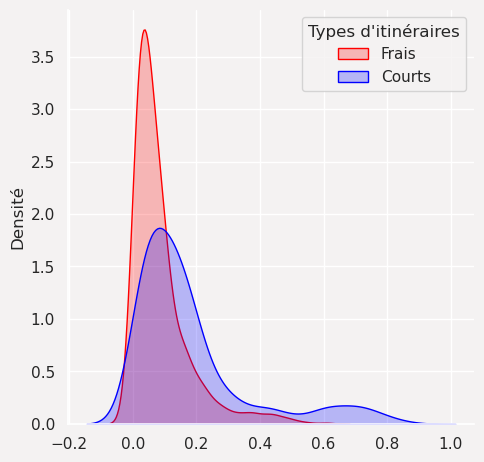

In [140]:
sns_plot(dataset_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01, "mean_ombres_13_prop")

In [143]:
print("IF : ", basic_stats(if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"]))
print("LEN : ", basic_stats(len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"]))

IF :         mean       var  quantiles
0  0.179975  0.034315       0.06
1  0.179975  0.034315       0.12
2  0.179975  0.034315       0.21
LEN :         mean       var  quantiles
0  0.086221  0.008556       0.03
1  0.086221  0.008556       0.06
2  0.086221  0.008556       0.11


In [146]:
ombre_gains = compare_gain(if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"], len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"])

Gain quantiles :  [  0.    66.66 216.66]
Gain mean :  249251.5120368098


In [147]:
#distance supplémentaire : 
distance_gains = compare_gain(if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["total_length"], len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["total_length"])

Gain quantiles :  [0.06  1.63  6.805]
Gain mean :  8.238588957055214


## Analyse P0_01O9At0_01Ar10C0_01E0_01Ca3
Praire : 0.01, Ombre : 9, Arbustes : 0.01, Arbres : 10, Température : 0.01, Eau : 0.01, Canopé : 3.

In [148]:
dataset_P0_01O9At0_01Ar10C0_01E0_01Ca3, it_if_P0_01O9At0_01Ar10C0_01E0_01Ca3, it_len_P0_01O9At0_01Ar10C0_01E0_01Ca3 = load_dataset("P0_01O9At0_01Ar10C0_01E0_01Ca3")

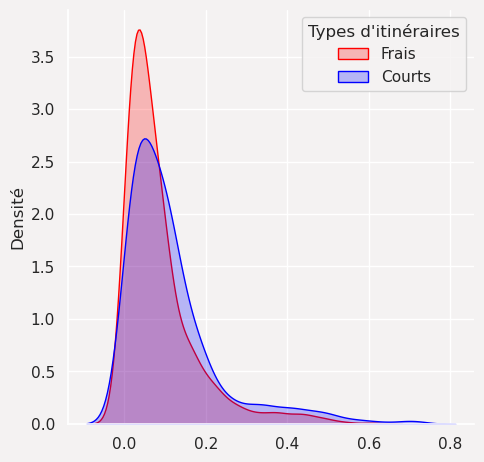

In [149]:
sns_plot(dataset_P0_01O9At0_01Ar10C0_01E0_01Ca3, "mean_ombres_13_prop")

In [152]:
print("LEN : ", basic_stats(len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"]))
print("IF 09 :", basic_stats(it_if_P0_01O9At0_01Ar10C0_01E0_01Ca3["mean_ombres_13_prop"]))
print("IF max: ", basic_stats(if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"]))

LEN :         mean       var  quantiles
0  0.086221  0.008556       0.03
1  0.086221  0.008556       0.06
2  0.086221  0.008556       0.11
IF 09 :        mean       var  quantiles
0  0.114245  0.013909       0.04
1  0.114245  0.013909       0.08
2  0.114245  0.013909       0.14
IF max:         mean       var  quantiles
0  0.179975  0.034315       0.06
1  0.179975  0.034315       0.12
2  0.179975  0.034315       0.21


In [157]:
ombres_gains_09 = compare_gain(it_if_P0_01O9At0_01Ar10C0_01E0_01Ca3["mean_ombres_13_prop"], it_len_P0_01O9At0_01Ar10C0_01E0_01Ca3["mean_ombres_13_prop"])
ombres_gains_max = compare_gain(if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"], len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"])

Gain quantiles :  [ 0.    0.   59.07]
Gain mean :  78584.86171779141
Gain quantiles :  [  0.    66.66 216.66]
Gain mean :  249251.5120368098


In [156]:
ombres_gains_09 = compare_gain(it_if_P0_01O9At0_01Ar10C0_01E0_01Ca3["total_length"], it_len_P0_01O9At0_01Ar10C0_01E0_01Ca3["total_length"])
ombres_gains_max = compare_gain(if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["total_length"], len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["total_length"])

Gain quantiles :  [0.    0.85  3.155]
Gain mean :  2.574723926380368
Gain quantiles :  [0.06  1.63  6.805]
Gain mean :  8.238588957055214


Arbres

In [159]:
print("LEN : ", basic_stats(len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_arbres_prop"]))
print("IF ombre 09 :", basic_stats(it_if_P0_01O9At0_01Ar10C0_01E0_01Ca3["mean_arbres_prop"]))
# print("IF max: ", basic_stats(if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_arbres_prop"]))

LEN :         mean       var  quantiles
0  0.220245  0.014915       0.13
1  0.220245  0.014915       0.20
2  0.220245  0.014915       0.29
IF ombre 09 :        mean       var  quantiles
0  0.291767  0.024853       0.18
1  0.291767  0.024853       0.27
2  0.291767  0.024853       0.39


In [161]:
gains_arbres_ombre_09 = compare_gain(it_if_P0_01O9At0_01Ar10C0_01E0_01Ca3["mean_arbres_prop"], len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_arbres_prop"])

Gain quantiles :  [ 0.   12.5  53.85]
Gain mean :  45.952110429447856


parcs

In [162]:
print("LEN : ", basic_stats(len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_canop"]))
print("IF ombre 09 :", basic_stats(it_if_P0_01O9At0_01Ar10C0_01E0_01Ca3["mean_canop"]))

LEN :         mean       var  quantiles
0  0.047104  0.007047       0.00
1  0.047104  0.007047       0.00
2  0.047104  0.007047       0.06
IF ombre 09 :        mean       var  quantiles
0  0.060172  0.008953       0.00
1  0.060172  0.008953       0.01
2  0.060172  0.008953       0.09


In [163]:
gains_canop_ombre_09 = compare_gain(it_if_P0_01O9At0_01Ar10C0_01E0_01Ca3["mean_canop"], len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_canop"])

Gain quantiles :  [0. 0. 0.]
Gain mean :  582843.5104907976


## Analyse P0_01O7At0_01Ar10C0_01E0_01Ca3
Praire : 0.01, Ombre : 7, Arbustes : 0.01, Arbres : 10, Température : 0.01, Eau : 0.01, Canopé : 3.

In [164]:
dataset_P0_01O7At0_01Ar10C0_01E0_01Ca3, it_if_P0_01O7At0_01Ar10C0_01E0_01Ca3, it_len_P0_01O7At0_01Ar10C0_01E0_01Ca3 = load_dataset("P0_01O7At0_01Ar10C0_01E0_01Ca3")

In [165]:
print("LEN : ", basic_stats(len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"]))
print("IF 07 :", basic_stats(it_if_P0_01O7At0_01Ar10C0_01E0_01Ca3["mean_ombres_13_prop"]))
print("IF max: ", basic_stats(if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"]))

LEN :         mean       var  quantiles
0  0.086221  0.008556       0.03
1  0.086221  0.008556       0.06
2  0.086221  0.008556       0.11
IF 07 :        mean       var  quantiles
0  0.106025  0.011802      0.035
1  0.106025  0.011802      0.080
2  0.106025  0.011802      0.130
IF max:         mean       var  quantiles
0  0.179975  0.034315       0.06
1  0.179975  0.034315       0.12
2  0.179975  0.034315       0.21


In [166]:
ombres_gains_7 = compare_gain(it_if_P0_01O7At0_01Ar10C0_01E0_01Ca3["mean_ombres_13_prop"], it_len_P0_01O9At0_01Ar10C0_01E0_01Ca3["mean_ombres_13_prop"])
ombres_gains_max = compare_gain(if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"], len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"])

Gain quantiles :  [ 0.  0. 50.]
Gain mean :  73665.51644171779
Gain quantiles :  [  0.    66.66 216.66]
Gain mean :  249251.5120368098


In [170]:
arbres_ombres_gains_7 = compare_gain(it_if_P0_01O7At0_01Ar10C0_01E0_01Ca3["mean_arbres_prop"], it_len_P0_01O7At0_01Ar10C0_01E0_01Ca3["mean_arbres_prop"])

Gain quantiles :  [ 0.    19.35  61.325]
Gain mean :  51.49530061349693


In [171]:
canop_ombres_gains_7 = compare_gain(it_if_P0_01O7At0_01Ar10C0_01E0_01Ca3["mean_canop"], it_len_P0_01O9At0_01Ar10C0_01E0_01Ca3["mean_canop"])

Gain quantiles :  [0. 0. 0.]
Gain mean :  639286.94602454


In [172]:
dist_gain_ombre_7 = compare_gain(it_if_P0_01O7At0_01Ar10C0_01E0_01Ca3["total_length"], it_len_P0_01O9At0_01Ar10C0_01E0_01Ca3["total_length"])

Gain quantiles :  [0.01  0.92  3.595]
Gain mean :  2.8355337423312883


## Analyse P0_01O5At0_01Ar10C0_01E0_01Ca3
Praire : 0.01, Ombre : 5, Arbustes : 0.01, Arbres : 10, Température : 0.01, Eau : 0.01, Canopé : 3.

In [173]:
data_set_P0_01O5At0_01Ar10C0_01E0_01Ca3, it_if_P0_01O5At0_01Ar10C0_01E0_01Ca3, it_len_P0_01O5At0_01Ar10C0_01E0_01Ca3 = load_dataset("P0_01O5At0_01Ar10C0_01E0_01Ca3")

In [174]:
print("LEN : ", basic_stats(len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"]))
print("IF 05 :", basic_stats(it_if_P0_01O5At0_01Ar10C0_01E0_01Ca3["mean_ombres_13_prop"]))
print("IF max: ", basic_stats(if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"]))

LEN :         mean       var  quantiles
0  0.086221  0.008556       0.03
1  0.086221  0.008556       0.06
2  0.086221  0.008556       0.11
IF 05 :        mean       var  quantiles
0  0.098638  0.010399       0.03
1  0.098638  0.010399       0.07
2  0.098638  0.010399       0.12
IF max:         mean       var  quantiles
0  0.179975  0.034315       0.06
1  0.179975  0.034315       0.12
2  0.179975  0.034315       0.21


In [175]:
ombres_gains_5 = compare_gain(it_if_P0_01O5At0_01Ar10C0_01E0_01Ca3["mean_ombres_13_prop"], it_len_P0_01O9At0_01Ar10C0_01E0_01Ca3["mean_ombres_13_prop"])
ombres_gains_max = compare_gain(if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"], len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"])

Gain quantiles :  [ 0.   0.  37.5]
Gain mean :  58932.66625766872
Gain quantiles :  [  0.    66.66 216.66]
Gain mean :  249251.5120368098


In [176]:
arbres_ombres_gains_5 = compare_gain(it_if_P0_01O5At0_01Ar10C0_01E0_01Ca3["mean_arbres_prop"], it_len_P0_01O7At0_01Ar10C0_01E0_01Ca3["mean_arbres_prop"])

Gain quantiles :  [ 0.    25.    74.455]
Gain mean :  59.11677300613497


In [177]:
canop_ombres_gains_5 = compare_gain(it_if_P0_01O5At0_01Ar10C0_01E0_01Ca3["mean_canop"], it_len_P0_01O9At0_01Ar10C0_01E0_01Ca3["mean_canop"])

Gain quantiles :  [0. 0. 0.]
Gain mean :  732540.8279386503


In [178]:
dist_gain_ombre_5 = compare_gain(it_if_P0_01O5At0_01Ar10C0_01E0_01Ca3["total_length"], it_len_P0_01O9At0_01Ar10C0_01E0_01Ca3["total_length"])

Gain quantiles :  [0.04  1.21  4.395]
Gain mean :  3.4963312883435584


## Analyse P0_01O3At0_01Ar10C0_01E0_01Ca3
Praire : 0.01, Ombre : 3, Arbustes : 0.01, Arbres : 10, Température : 0.01, Eau : 0.01, Canopé : 3.

In [179]:
dataset_P0_01O3At0_01Ar10C0_01E0_01Ca3, it_if_P0_01O3At0_01Ar10C0_01E0_01Ca3, it_len_P0_01O3At0_01Ar10C0_01E0_01Ca3 = load_dataset("P0_01O3At0_01Ar10C0_01E0_01Ca3")

In [181]:
print("LEN : ", basic_stats(len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"]))
print("IF 03 :", basic_stats(it_if_P0_01O3At0_01Ar10C0_01E0_01Ca3["mean_ombres_13_prop"]))
print("IF max: ", basic_stats(if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"]))

LEN :         mean       var  quantiles
0  0.086221  0.008556       0.03
1  0.086221  0.008556       0.06
2  0.086221  0.008556       0.11
IF 03 :        mean      var  quantiles
0  0.091399  0.00908       0.03
1  0.091399  0.00908       0.07
2  0.091399  0.00908       0.11
IF max:         mean       var  quantiles
0  0.179975  0.034315       0.06
1  0.179975  0.034315       0.12
2  0.179975  0.034315       0.21


In [182]:
ombres_gains_3 = compare_gain(it_if_P0_01O3At0_01Ar10C0_01E0_01Ca3["mean_ombres_13_prop"], it_len_P0_01O9At0_01Ar10C0_01E0_01Ca3["mean_ombres_13_prop"])
ombres_gains_max = compare_gain(if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"], len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"])

Gain quantiles :  [-3.225  0.    33.33 ]
Gain mean :  56469.86501840491
Gain quantiles :  [  0.    66.66 216.66]
Gain mean :  249251.5120368098


In [183]:
arbres_ombres_gains_3 = compare_gain(it_if_P0_01O3At0_01Ar10C0_01E0_01Ca3["mean_arbres_prop"], it_len_P0_01O7At0_01Ar10C0_01E0_01Ca3["mean_arbres_prop"])

Gain quantiles :  [ 0.98  31.25  89.885]
Gain mean :  67.64242944785276


In [184]:
canop_ombres_gains_3 = compare_gain(it_if_P0_01O3At0_01Ar10C0_01E0_01Ca3["mean_canop"], it_len_P0_01O9At0_01Ar10C0_01E0_01Ca3["mean_canop"])

Gain quantiles :  [ 0.     0.    11.435]
Gain mean :  856471.7212147239


In [185]:
dist_gain_ombre_3 = compare_gain(it_if_P0_01O3At0_01Ar10C0_01E0_01Ca3["total_length"], it_len_P0_01O9At0_01Ar10C0_01E0_01Ca3["total_length"])

Gain quantiles :  [0.11  1.78  5.455]
Gain mean :  4.467644171779142


## Analyse P0_01O1At0_01Ar10C0_01E0_01Ca3
Praire : 0.01, Ombre : 1, Arbustes : 0.01, Arbres : 10, Température : 0.01, Eau : 0.01, Canopé : 3.

In [186]:
dataset_P0_01O1At0_01Ar10C0_01E0_01Ca3, it_if_P0_01O1At0_01Ar10C0_01E0_01Ca3, it_len_P0_01O1At0_01Ar10C0_01E0_01Ca3 = load_dataset("P0_01O1At0_01Ar10C0_01E0_01Ca3")

In [187]:
print("LEN : ", basic_stats(len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"]))
print("IF 01 :", basic_stats(it_if_P0_01O1At0_01Ar10C0_01E0_01Ca3["mean_ombres_13_prop"]))
print("IF max: ", basic_stats(if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"]))

LEN :         mean       var  quantiles
0  0.086221  0.008556       0.03
1  0.086221  0.008556       0.06
2  0.086221  0.008556       0.11
IF 01 :        mean       var  quantiles
0  0.080331  0.006572       0.03
1  0.080331  0.006572       0.06
2  0.080331  0.006572       0.10
IF max:         mean       var  quantiles
0  0.179975  0.034315       0.06
1  0.179975  0.034315       0.12
2  0.179975  0.034315       0.21


In [188]:
ombres_gains_1 = compare_gain(it_if_P0_01O1At0_01Ar10C0_01E0_01Ca3["mean_ombres_13_prop"], it_len_P0_01O9At0_01Ar10C0_01E0_01Ca3["mean_ombres_13_prop"])
ombres_gains_max = compare_gain(if_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"], len_it_P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01["mean_ombres_13_prop"])

Gain quantiles :  [-21.06   0.    16.67]
Gain mean :  55229.88247852761
Gain quantiles :  [  0.    66.66 216.66]
Gain mean :  249251.5120368098


In [189]:
arbres_ombres_gains_1 = compare_gain(it_if_P0_01O1At0_01Ar10C0_01E0_01Ca3["mean_arbres_prop"], it_len_P0_01O7At0_01Ar10C0_01E0_01Ca3["mean_arbres_prop"])

Gain quantiles :  [  5.74  40.   108.01]
Gain mean :  77.99719018404909


In [190]:
canop_ombres_gains_1 = compare_gain(it_if_P0_01O1At0_01Ar10C0_01E0_01Ca3["mean_canop"], it_len_P0_01O9At0_01Ar10C0_01E0_01Ca3["mean_canop"])

Gain quantiles :  [ 0.     0.    36.065]
Gain mean :  992671.0872638036


## Analyse P0_01O9At0_01Ar10C0_01E0_01Ca0_01
Praire : 0.01, Ombre : 9, Arbustes : 0.01, Arbres : 10, Température : 0.01, Eau : 0.01, Canopé : 0.01.

In [73]:
data_set_prop_csv_P0_01O9At0_01Ar10C0_01E0_01Ca0_01 = pd.read_csv("./output_data/analyse/P0_01O9At0_01Ar10C0_01E0_01Ca0_01/mean_value_by_itP0_01O9At0_01Ar10C0_01E0_01Ca0_01.csv")

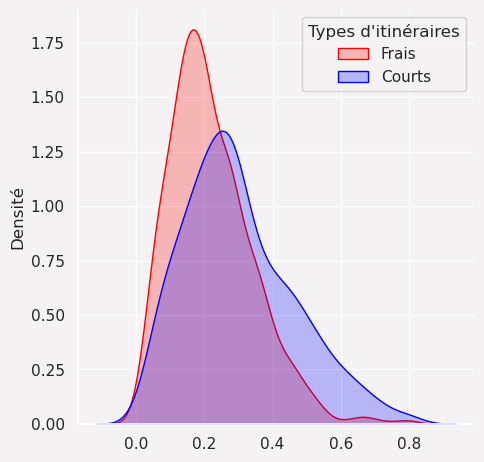

In [79]:
sns_plot(data_set_prop_csv_P0_01O9At0_01Ar10C0_01E0_01Ca0_01, "mean_arbres_prop")

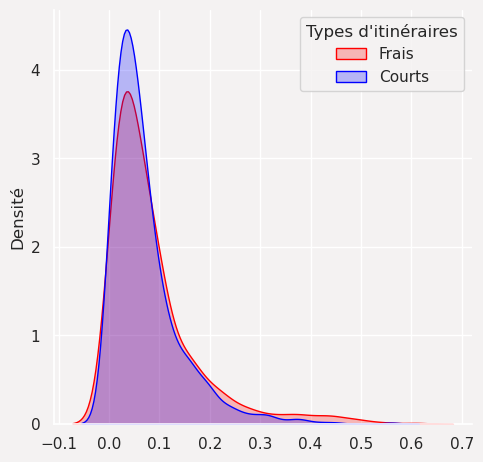

In [87]:
sns_plot(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01, "mean_ombres_13_prop")

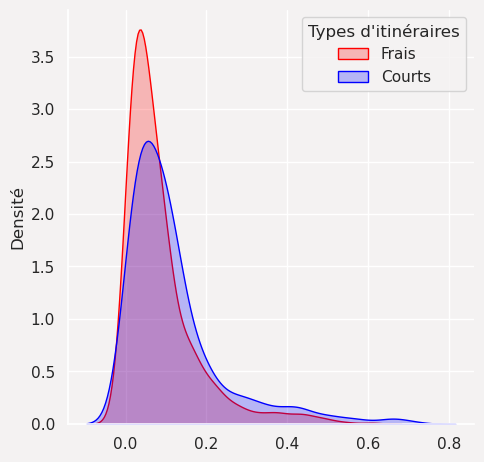

In [85]:
sns_plot(data_set_prop_csv_P0_01O9At0_01Ar10C0_01E0_01Ca0_01, "mean_ombres_13_prop")

### Test de student entre prop ombre court et frais

In [91]:
def basic_stats(data):
    return pd.DataFrame({
        "mean": np.mean(data),
        "var": np.var(data),
        "quantiles": np.quantile(data, q=[0.25,0.5,0.75])
    })

In [89]:
ombre_if = data_set_prop_csv_P0_01O9At0_01Ar10C0_01E0_01Ca0_01[data_set_prop_csv_P0_01O9At0_01Ar10C0_01E0_01Ca0_01["type"] == "IF"]["mean_ombres_13_prop"]
ombre_len = data_set_prop_csv_P0_01O9At0_01Ar10C0_01E0_01Ca0_01[data_set_prop_csv_P0_01O9At0_01Ar10C0_01E0_01Ca0_01["type"] == "LEN"]["mean_ombres_13_prop"]

In [92]:
print(basic_stats(ombre_if))

      mean       var  quantiles
0  0.11811  0.015075       0.04
1  0.11811  0.015075       0.08
2  0.11811  0.015075       0.14


In [93]:
print(basic_stats(ombre_len))

       mean       var  quantiles
0  0.086221  0.008556       0.03
1  0.086221  0.008556       0.06
2  0.086221  0.008556       0.11


In [90]:
test_students(ombre_len, ombre_if)

TtestResult(statistic=-15.601535559865992, pvalue=3.3197015877582293e-48, df=814)

### Test de student entre prop pondéré à 0.01 et 9

In [94]:
ombre_if_001 = data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01[data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01["type"] == "IF"]["mean_ombres_13_prop"]

In [95]:
print(basic_stats(ombre_if_001))

       mean       var  quantiles
0  0.071448  0.004875       0.03
1  0.071448  0.004875       0.05
2  0.071448  0.004875       0.09


In [96]:
test_students(ombre_if_001, ombre_if)

TtestResult(statistic=-16.95017109989101, pvalue=2.0136557335219777e-55, df=814)

In [97]:
d_cohen(ombre_if_001, ombre_if)

-0.46671330688954604

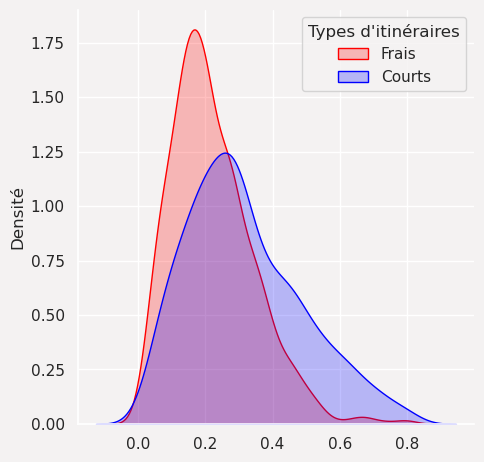

In [81]:
data_set_prop_csv_P0_01O7At0_01Ar10C0_01E0_01Ca0_01 = pd.read_csv("./output_data/analyse/P0_01O7At0_01Ar10C0_01E0_01Ca0_01/mean_value_by_itP0_01O7At0_01Ar10C0_01E0_01Ca0_01.csv")
sns_plot(data_set_prop_csv_P0_01O7At0_01Ar10C0_01E0_01Ca0_01, "mean_arbres_prop")

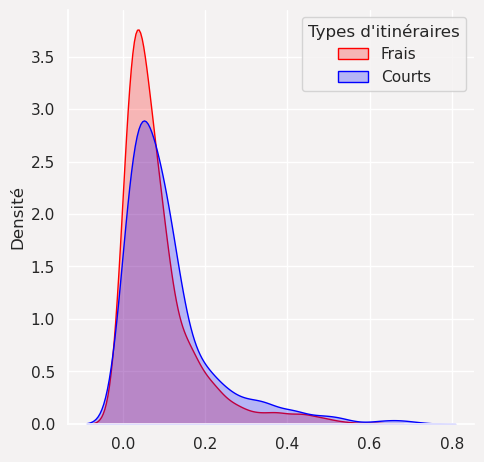

In [86]:
data_set_prop_csv_P0_01O7At0_01Ar10C0_01E0_01Ca0_01 = pd.read_csv("./output_data/analyse/P0_01O7At0_01Ar10C0_01E0_01Ca0_01/mean_value_by_itP0_01O7At0_01Ar10C0_01E0_01Ca0_01.csv")
sns_plot(data_set_prop_csv_P0_01O7At0_01Ar10C0_01E0_01Ca0_01, "mean_ombres_13_prop")

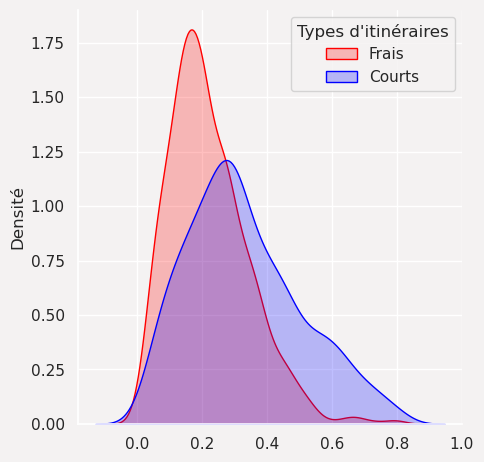

In [82]:
data_set_prop_csv_P0_01O5At0_01Ar10C0_01E0_01Ca0_01 = pd.read_csv("./output_data/analyse/P0_01O5At0_01Ar10C0_01E0_01Ca0_01/mean_value_by_itP0_01O5At0_01Ar10C0_01E0_01Ca0_01.csv")
sns_plot(data_set_prop_csv_P0_01O5At0_01Ar10C0_01E0_01Ca0_01, "mean_arbres_prop")

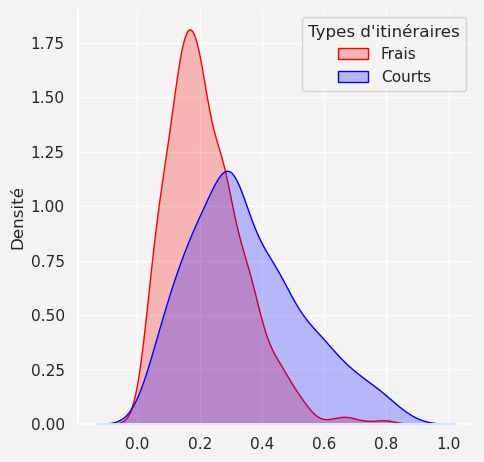

In [83]:
data_set_prop_csv_P0_01O3At0_01Ar10C0_01E0_01Ca0_01 = pd.read_csv("./output_data/analyse/P0_01O3At0_01Ar10C0_01E0_01Ca0_01/mean_value_by_itP0_01O3At0_01Ar10C0_01E0_01Ca0_01.csv")
sns_plot(data_set_prop_csv_P0_01O3At0_01Ar10C0_01E0_01Ca0_01, "mean_arbres_prop")

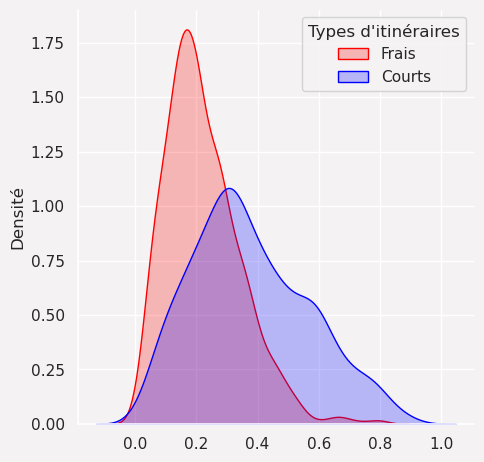

In [84]:
data_set_prop_csv_P0_01O1At0_01Ar10C0_01E0_01Ca0_01 = pd.read_csv("./output_data/analyse/P0_01O1At0_01Ar10C0_01E0_01Ca0_01/mean_value_by_itP0_01O1At0_01Ar10C0_01E0_01Ca0_01.csv")
sns_plot(data_set_prop_csv_P0_01O1At0_01Ar10C0_01E0_01Ca0_01, "mean_arbres_prop")

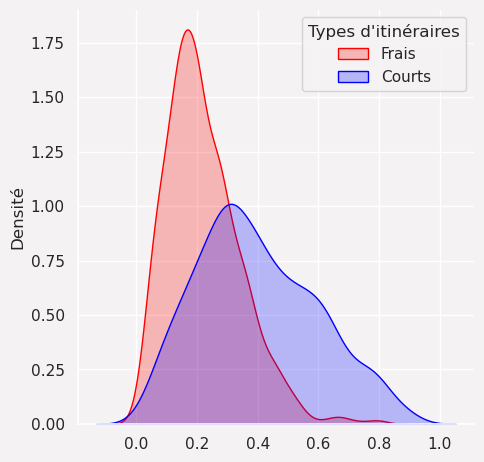

In [80]:
sns_plot(data_set_prop_csv_P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01, "mean_arbres_prop")

### Analyse ombre 18h

In [98]:
data_set_prop_csv_P0_01O9At0_01Ar10C0_01E0_01Ca0_01_18h = pd.read_csv("./output_data/analyse/P0_01O9At0_01Ar10C0_01E0_01Ca0_01/18h/mean_value_by_itP0_01O9At0_01Ar10C0_01E0_01Ca0_01.csv")

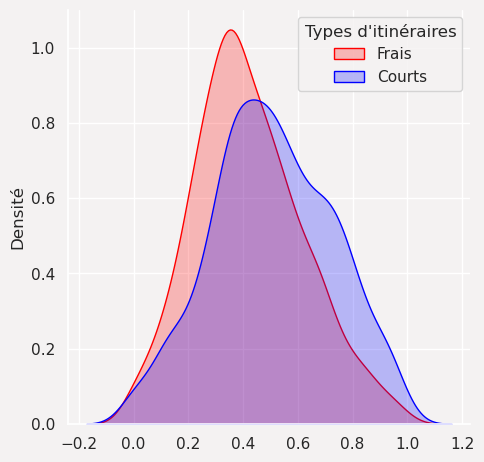

In [100]:
sns_plot(data_set_prop_csv_P0_01O9At0_01Ar10C0_01E0_01Ca0_01_18h, "mean_ombres_18_prop")

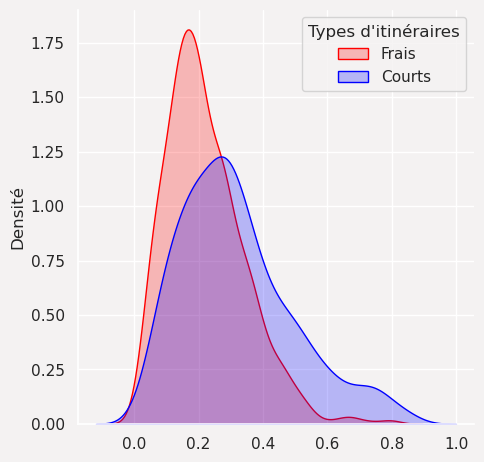

In [101]:
sns_plot(data_set_prop_csv_P0_01O9At0_01Ar10C0_01E0_01Ca0_01_18h, "mean_arbres_prop")

## Analyse P1O1At1Ar10C1E1Ca1
Praire : 1, Ombre : 1, Arbustes : 1, Arbres : 10, Température : 1, Eau : 1, Canopé : 1.

Les individus statistiques sont bien les itinéraires, que l'on va pouvoir comparer en fonction du traitement que l'on applique (pondération)
On va chercher à caractériser chacun des itinéraires en fonction de leur proportion en telle ou telle données

Un peu de stats : Dans le cas du test de Kolmogorov-Smirnov avec deux échantillons, on compare la distribution de deux échantillons (l'un théorique, dans notre cas, on prend la distirbution de l'itinéraire le plus court comme étant théorique). Il faut vérifier la p-value mais surtout le statistique de test. 
Attention, est-ce vraiment pertinent de regarder les distributions ? Pour moi il s'agit plutôt d'une comparaison de deux moyennes comme un test de student mais dans le cas de la plupart des données, les distributions ne sont pas normales.

Hypoothèse pour un test de student : 
* indépendances (sauf dans un cas avec données appariées, comme les notres) car dépendance de la distance
* échantillon aléatoire dans la population : OUI
* données dans chaque groupe distribué normalement : NON pour la plupart des données, sauf pour les arbres
* valeur des données continues : OUI
* variance pour les deux groupes indépenants égales : à vérifier, mais est-ce nécessaire dans le cas de groupe dépendants ? 
* Se pose la question de la taille des échantillons ..

In [14]:
data_set__prop_csv_P1O1At1Ar10C1E1Ca1 = pd.read_csv("./output_data/analyse/P1O1At1Ar10C1E1Ca1/mean_value_by_it_P1O1At1Ar10C1E1Ca1.csv")

In [15]:
data_set__prop_csv_P1O1At1Ar10C1E1Ca1.columns

Index(['id_it', 'type', 'mean_prairies_prop', 'mean_arbustes_prop',
       'mean_arbres_prop', 'mean_C_wavg_scaled', 'mean_eaux_prop',
       'mean_canop', 'mean_ombres_08_prop', 'mean_ombres_13_prop',
       'mean_ombres_18_prop', 'total_length', 'mean_score', 'score_10'],
      dtype='object')

In [16]:
np.max(data_set__prop_csv_P1O1At1Ar10C1E1Ca1["total_length"])

4633.49

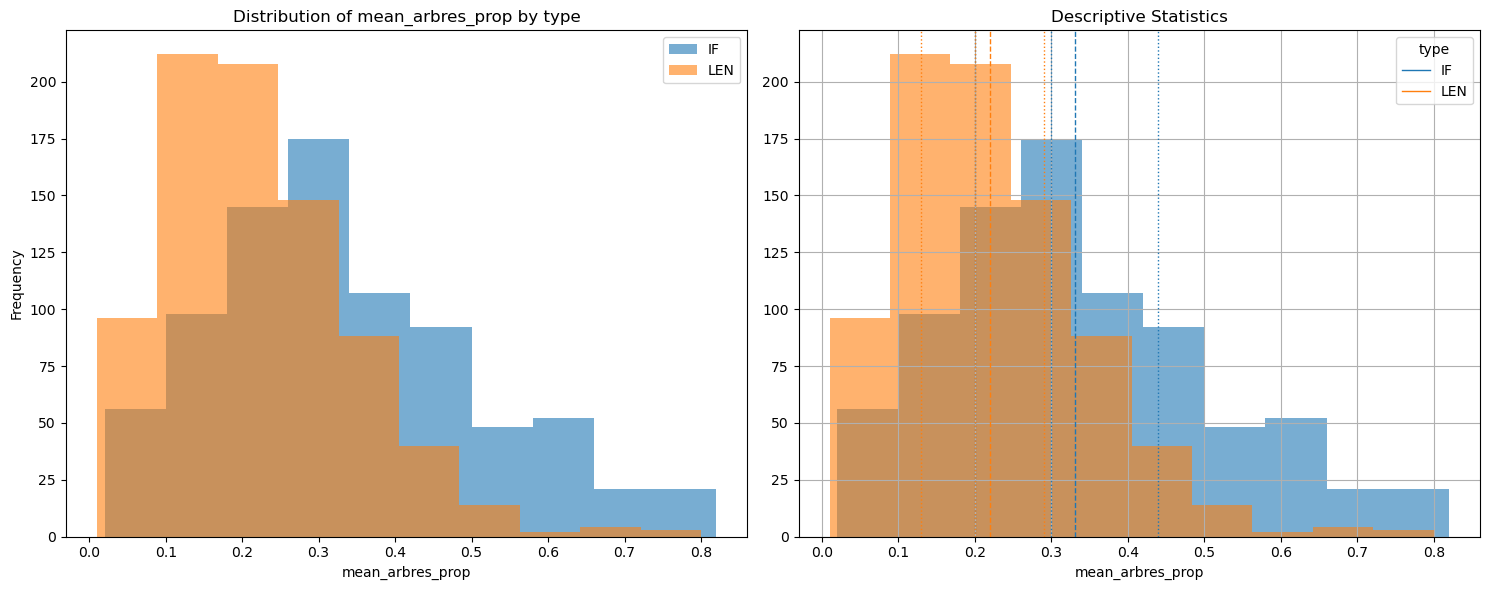

In [8]:
# Utilisation de la fonction pour le DataFrame "df" et les colonnes "mean_arbres_prop" et "type"
plot_distribution_by_category(data_set__prop_csv_P1O1At1Ar10C1E1Ca1, target_column='mean_arbres_prop', category_column='type')

Test de student avec données dépendantes. Individu stat avec traitement (pondération)

In [9]:
it_if_P1O1At1Ar10C1E1Ca1 = data_set__prop_csv_P1O1At1Ar10C1E1Ca1[data_set__prop_csv_P1O1At1Ar10C1E1Ca1["type"] == "IF"]
it_if_P1O1At1Ar10C1E1Ca1 = it_if_P1O1At1Ar10C1E1Ca1.set_index(["id_it"])
it_len_P1O1At1Ar10C1E1Ca1 = data_set__prop_csv_P1O1At1Ar10C1E1Ca1[data_set__prop_csv_P1O1At1Ar10C1E1Ca1["type"] == "LEN"]
it_len_P1O1At1Ar10C1E1Ca1 = it_len_P1O1At1Ar10C1E1Ca1.set_index(["id_it"])

In [31]:
mean_if = np.mean(it_if_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"])
mean_len = np.mean(it_len_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"])

sd_if = np.std(it_if_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"])
sd_len = np.std(it_len_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"])

print("mean if : ", mean_if)
print("sd if : ", sd_if)
print("mean len : ", mean_len)
print("sd len : ", sd_len)

mean if :  0.330478527607362
sd if :  0.17350629264673978
mean len :  0.22024539877300614
sd len :  0.12212610861404323


In [32]:
quantiles_if = np.quantile(it_if_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"], q=[0.25,0.5,0.75])
quantiles_len = np.quantile(it_len_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"], q=[0.25,0.5,0.75])

print("quantiles_if: ",quantiles_if)
print("quantiles_len: ", quantiles_len)

quantiles_if:  [0.2  0.3  0.44]
quantiles_len:  [0.13 0.2  0.29]


In [25]:
var_if = np.var(it_if_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"])
var_len = np.var(it_len_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"])
print("var_if : ", var_if)
print("var_len : ", var_len)
test_students(it_len_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"], it_if_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"])

var_if :  0.030104433588016108
var_len :  0.014914786405209084


TtestResult(statistic=-25.72087967448124, pvalue=3.008035990456993e-107, df=814)

In [23]:
ks_2samp_test(it_len_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"], it_if_P1O1At1Ar10C1E1Ca1["mean_arbres_prop"], alternative="two-sided")

KS statistics :  0.29938650306748466
p-value :  1.2713803941483416e-32


(0.29938650306748466, 1.2713803941483416e-32)

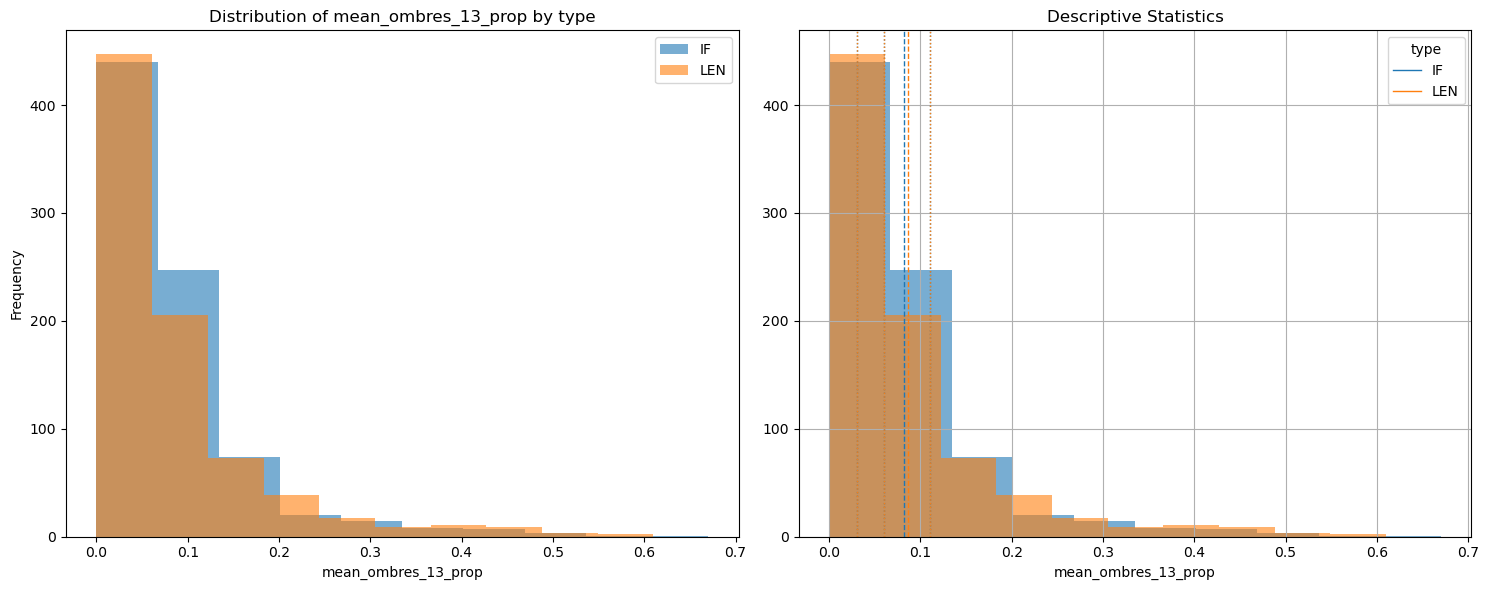

In [11]:
plot_distribution_by_category(data_set__prop_csv_P1O1At1Ar10C1E1Ca1, target_column='mean_ombres_13_prop', category_column='type')

In [21]:
ks_2samp_test(it_len_P1O1At1Ar10C1E1Ca1["mean_ombres_13_prop"], it_if_P1O1At1Ar10C1E1Ca1["mean_ombres_13_prop"], alternative="two-sided")

KS statistics :  0.03680981595092025
p-value :  0.6391627574813673


(0.03680981595092025, 0.6391627574813673)

H0 : les deux distributions sont égales, donc si p-value > 0.05, on ne peut pas rejetter H0, ce qui est le cas ici.

In [22]:
ks_2samp_test(it_len_P1O1At1Ar10C1E1Ca1["mean_prairies_prop"], it_if_P1O1At1Ar10C1E1Ca1["mean_prairies_prop"], alternative="two-sided")

KS statistics :  0.04785276073619632
p-value :  0.30839938137975775


(0.04785276073619632, 0.30839938137975775)

In [26]:
ks_2samp_test(it_len_P1O1At1Ar10C1E1Ca1["mean_arbustes_prop"], it_if_P1O1At1Ar10C1E1Ca1["mean_arbustes_prop"], alternative="two-sided")

KS statistics :  0.03558282208588957
p-value :  0.6809241316686812


(0.03558282208588957, 0.6809241316686812)

In [27]:
ks_2samp_test(it_len_P1O1At1Ar10C1E1Ca1["mean_C_wavg_scaled"], it_if_P1O1At1Ar10C1E1Ca1["mean_C_wavg_scaled"], alternative="two-sided")

KS statistics :  0.06134969325153374
p-value :  0.09306301726771331


(0.06134969325153374, 0.09306301726771331)

In [28]:
test_students(it_len_P1O1At1Ar10C1E1Ca1["mean_C_wavg_scaled"], it_if_P1O1At1Ar10C1E1Ca1["mean_C_wavg_scaled"])

TtestResult(statistic=9.508913630459755, pvalue=2.1060598846445236e-20, df=814)

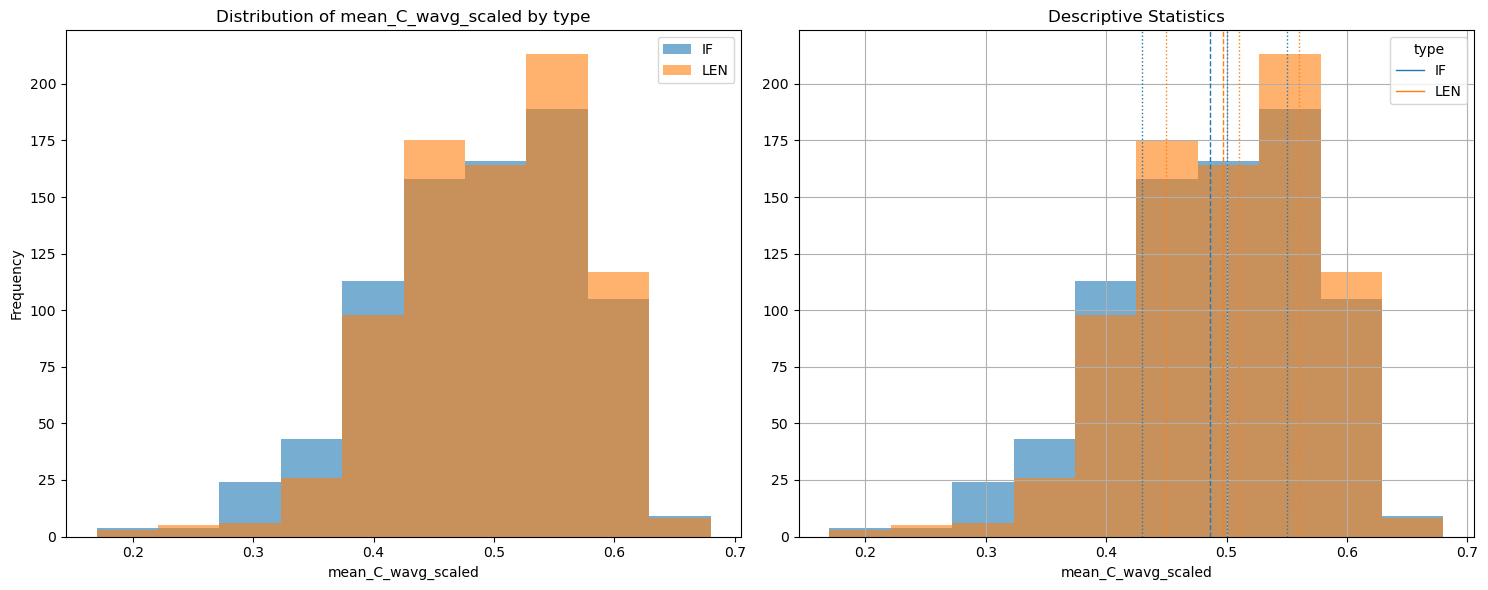

In [16]:
plot_distribution_by_category(data_set__prop_csv_P1O1At1Ar10C1E1Ca1, target_column='mean_C_wavg_scaled', category_column='type')

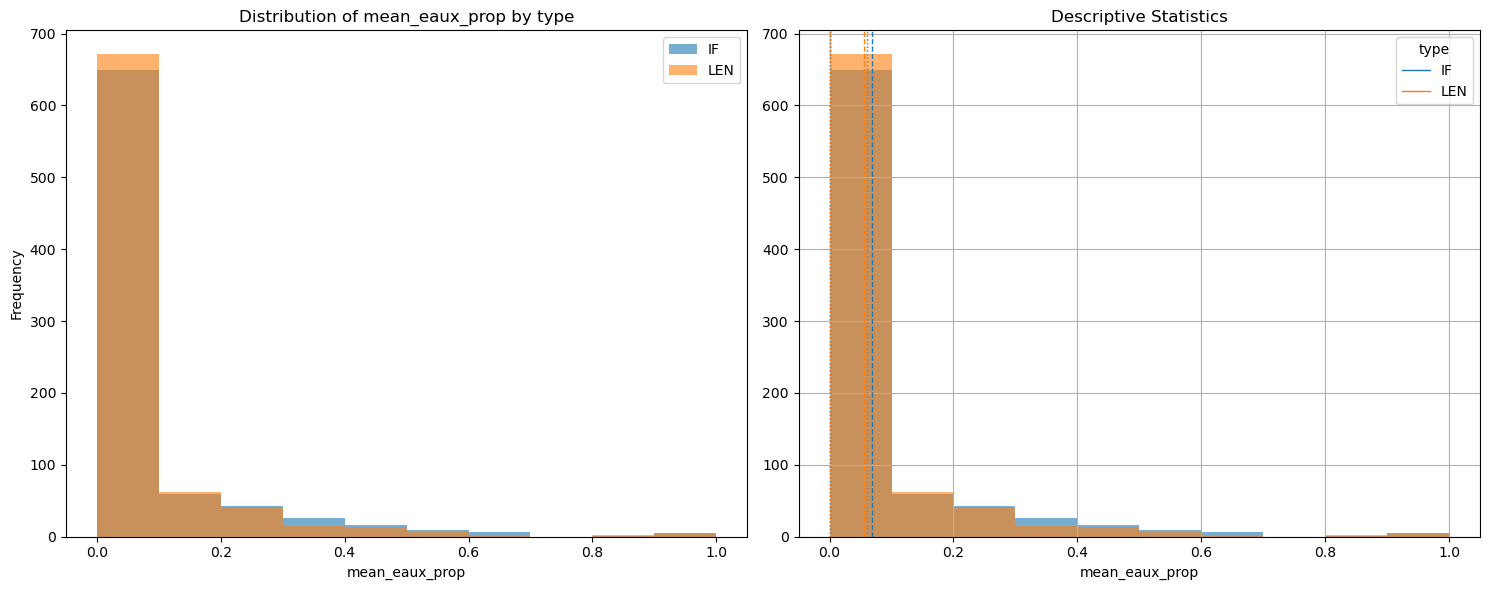

In [18]:
plot_distribution_by_category(data_set__prop_csv_P1O1At1Ar10C1E1Ca1, target_column='mean_eaux_prop', category_column='type')

In [29]:
ks_2samp_test(it_len_P1O1At1Ar10C1E1Ca1["mean_eaux_prop"], it_if_P1O1At1Ar10C1E1Ca1["mean_eaux_prop"], alternative="two-sided")

KS statistics :  0.04539877300613497
p-value :  0.37060604882127646


(0.04539877300613497, 0.37060604882127646)

In [30]:
print(distance_cost(it_len_P1O1At1Ar10C1E1Ca1, it_if_P1O1At1Ar10C1E1Ca1))

4.53
